In [9]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load the dataset from sklearn
housing = fetch_california_housing()

# Create DataFrame
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['MedHouseVal'] = housing.target

# Let me also check the content from your file
try:
    # Try to read the CSV file you provided
    df_file = pd.read_csv('housing.csv')
    print("✓ Successfully loaded data from provided CSV file")
    df = df_file  # Use the provided dataset since it's more comprehensive
except:
    print("⚠ Using sklearn dataset (fallback)")
    # Continue with sklearn dataset

print("\n" + "="*60)
print("DATASET ANALYSIS REPORT")
print("="*60)# 1. Shape of dataset
print("1. SHAPE OF DATASET")
print(f"   Rows: {df.shape[0]}")
print(f"   Columns: {df.shape[1]}")

# 2. Column names
print("\n2. COLUMN NAMES")
for i, col in enumerate(df.columns, 1):
    print(f"   {i}. {col}")

# 3. First 10 rows
print("\n3. FIRST 10 ROWS")
print(df.info())

print("\n5. BASIC STATISTICS")
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})
print(f"   Minimum: ${df['medianHouseValue'].min():,.2f}")
print(f"   Maximum: ${df['medianHouseValue'].max():,.2f}")
print(f"   Mean: ${df['medianHouseValue'].mean():,.2f}")
print(f"   Median: ${df['medianHouseValue'].median():,.2f}")
print(f"   Standard Deviation: ${df['medianHouseValue'].std():,.2f}")# Set up the visualization style
plt.style.use('seaborn-v0_8-darkgrid')

# 1. Distribution of house prices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['medianHouseValue'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Median House Value ($)')
plt.ylabel('Frequency')
plt.title('Distribution of House Prices')
plt.grid(True, alpha=0.3)

# 2. Correlation heatmap
plt.subplot(1, 2, 2)
# Select only numerical columns for correlation
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix')
plt.tight_layout()

# Check if ocean_proximity exists (categorical variable)
if 'ocean_proximity' in df.columns:
    print("   Categorical variable 'ocean_proximity' found:")
    print(f"   Unique values: {df['ocean_proximity'].unique()}")
    print(f"   Value counts:\n{df['ocean_proximity'].value_counts()}")
    
    # Create dummy variables for ocean_proximity
    df = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=True)
    print(f"   After one-hot encoding, columns: {len(df.columns)}")

# Create some new features that might be useful
if all(col in df.columns for col in ['total_rooms', 'households']):
    df['rooms_per_household'] = df['total_rooms'] / df['households']
    print("   Created feature: rooms_per_household")

if all(col in df.columns for col in ['total_bedrooms', 'total_rooms']):
    df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
    print("   Created feature: bedrooms_per_room")

if all(col in df.columns for col in ['population', 'households']):
    df['population_per_household'] = df['population'] / df['households']
print("MULTIPLE LINEAR REGRESSION MODEL")
print("="*60)

# Prepare the data
# Separate features and target
X = df.drop('medianHouseValue', axis=1)
y = df['medianHouseValue']

# Handle any missing values (if present)
if X.isnull().sum().sum() > 0:
    print("   Handling missing values...")
    # Fill missing values with median for numerical columns
    for col in X.select_dtypes(include=[np.number]).columns:
        X[col].fillna(X[col].median(), inplace=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"   Training set size: {X_train.shape[0]} samples")
print(f"   Testing set size: {X_test.shape[0]} samples")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print("\n9. MODEL PERFORMANCE METRICS")
print(f"   Training MSE: {train_mse:.4f}")
print(f"   Testing MSE: {test_mse:.4f}")
print(f"   Training R² Score: {train_r2:.4f}")
print(f"   Testing R² Score: {test_r2:.4f}")

# Check for overfitting
print(f"\n   Overfitting check (R² diff): {abs(train_r2 - test_r2):.4f}")
if abs(train_r2 - test_r2) < 0.1:
    print("   ✓ Model appears to generalize well")
else:
    print("   ⚠ Possible overfitting detected")

# Feature importance (coefficients)
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\n10. TOP 10 MOST IMPORTANT FEATURES")
print(coefficients.head(10).to_string(index=False))# Visualization of predictions vs actual values
plt.figure(figsize=(14, 5))

# 1. Training set predictions
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.5, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual House Values ($)')
plt.ylabel('Predicted House Values ($)')
plt.title('Training Set: Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Testing set predictions
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual House Values ($)')
plt.ylabel('Predicted House Values ($)')
plt.title('Testing Set: Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residual analysis
residuals = y_test - y_pred_test

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_test, residuals, alpha=0.5, color='purple')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values ($)')
plt.ylabel('Residuals ($)')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='orange')
plt.xlabel('Residuals ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)

plt.tight_layout()
print("BUSINESS INSIGHTS & RECOMMENDATIONS")
print("="*60)

print("\n11. KEY FINDINGS:")
print("   1. The multiple linear regression model explains approximately " 
      f"{test_r2*100:.1f}% of the variance in housing prices.")

print("   2. Most important predictors of house prices:")
for i, row in coefficients.head(5).iterrows():
    direction = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"      • {row['Feature']}: {direction} price by ${abs(row['Coefficient']):,.2f} per unit")

print("\n   3. Model Limitations:")
print("      • Linear regression assumes linear relationships")
print("      • May not capture complex non-linear patterns")
print("      • Sensitive to outliers in the data")

print("\n12. RECOMMENDATIONS FOR REAL ESTATE FIRM:")
print("   1. Focus on properties with higher median income in the block")
print("   2. Consider ocean proximity as a key pricing factor")
print("   3. Use the model for initial price estimations")
print("   4. Regularly update the model with new market data")
print("   5. Consider additional features like school quality, crime rates")

# Create a sample prediction
print("\n13. SAMPLE PREDICTION:")
sample_idx = 0
sample_features = X_test.iloc[[sample_idx]]
sample_actual = y_test.iloc[sample_idx]

# Scale the sample
sample_scaled = scaler.transform(sample_features)
sample_prediction = model.predict(sample_scaled)[0]

print(f"   Actual Price: ${sample_actual:,.2f}")
print(f"   Predicted Price: ${sample_prediction:,.2f}")
print(f"   Difference: ${abs(sample_actual - sample_prediction):,.2f}")
print("MODEL IMPROVEMENT SUGGESTIONS")
print("="*60)

print("\n14. POTENTIAL IMPROVEMENTS:")
print("   1. Try polynomial features to capture non-linear relationships")
print("   2. Use regularization techniques (Ridge/Lasso regression)")
print("   3. Experiment with other algorithms:")
print("      • Random Forest")
print("      • Gradient Boosting (XGBoost, LightGBM)")
print("      • Neural Networks")
print("   4. Feature selection to remove multicollinearity")
print("   5. Outlier detection and treatment")
print("   6. Cross-validation for more robust performance estimation")
print("   7. Ensemble methods combining multiple models")

✓ Successfully loaded data from provided CSV file

DATASET ANALYSIS REPORT
1. SHAPE OF DATASET
   Rows: 20640
   Columns: 10

2. COLUMN NAMES
   1. longitude
   2. latitude
   3. housing_median_age
   4. total_rooms
   5. total_bedrooms
   6. population
   7. households
   8. median_income
   9. median_house_value
   10. ocean_proximity

3. FIRST 10 ROWS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  flo

KeyError: 'medianHouseValue'

COMPREHENSIVE DATA ANALYSIS - CALIFORNIA HOUSING DATASET

1. DATASET INFORMATION (.info()):
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
Variance by feature (sorted from highest to lowest):
                              Variance      Std_Dev
median_house_value 13,316,148,163.0351 115,395.6159
total_rooms             4,759,445.1059   2,181.6153
population              1,282,470.4572   1,132.4621
total_bedrooms            177,565.3773     421.3851
households                146,176.0399     382.3298
housing_median_age            158.3963      12.5856
latitude                        4.5623       2.1360
longitude                       4.0141       2.0035
median_income                   3.6093       1.8998

⭐ FEATURE WITH LARGEST VARIANCE:
   Feature: 'median_house_value'
   Variance: 13,316,148,163.0351
   Standard Deviation: 115,395.

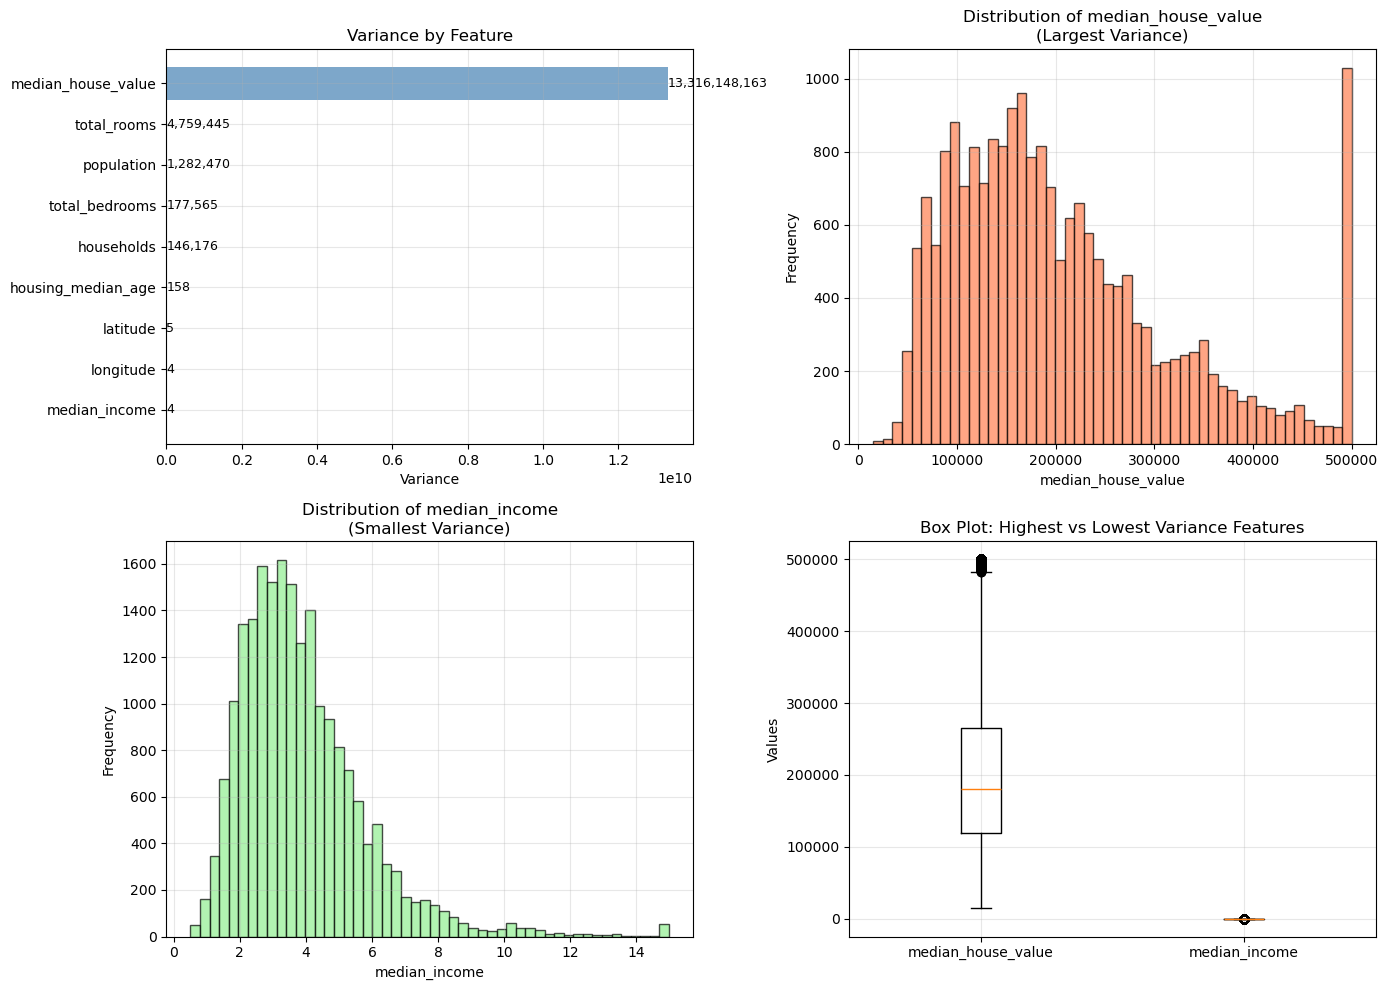

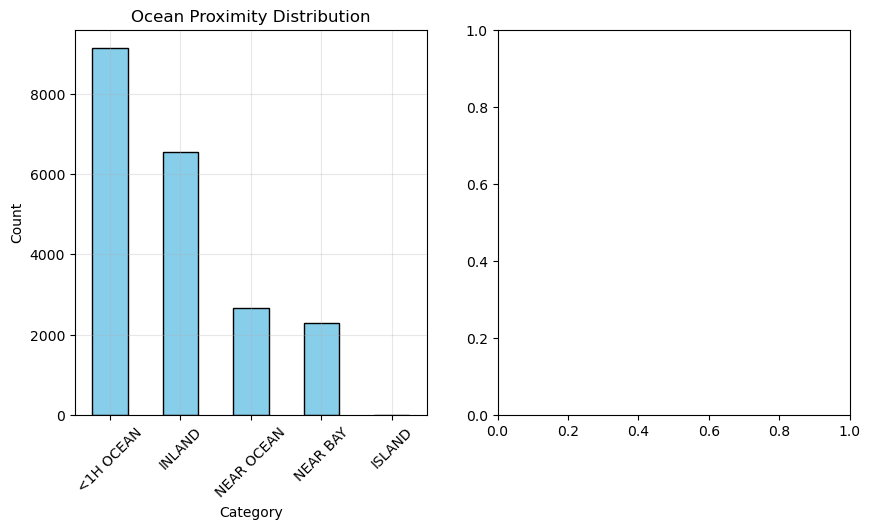

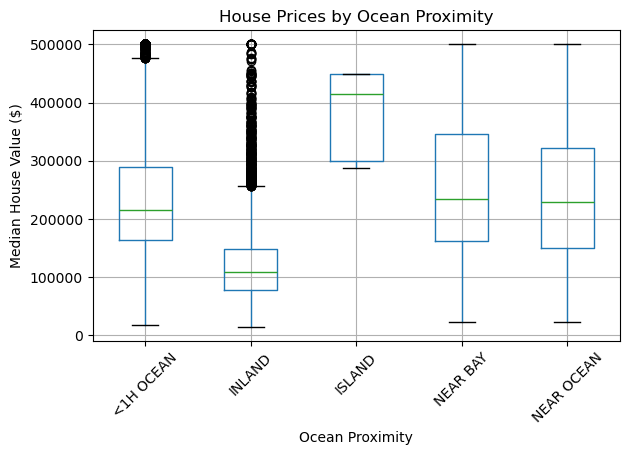

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from your file
df = pd.read_csv('housing.csv')

print("=" * 70)
print("COMPREHENSIVE DATA ANALYSIS - CALIFORNIA HOUSING DATASET")
print("=" * 70)

print("\n1. DATASET INFORMATION (.info()):")
print("-" * 50)
print("-" * 50)
print("-" * 50)

# Create a more detailed statistical summary
stats_df = pd.DataFrame()

for col in df.select_dtypes(include=[np.number]).columns:
    stats_df[col] = [
        df[col].count(),
        df[col].mean(),
        df[col].std(),
        df[col].var(),
        df[col].min(),
        df[col].quantile(0.25),
        df[col].median(),
        df[col].quantile(0.75),
        df[col].max(),
        df[col].skew(),
        df[col].kurtosis()
    ]

stats_df.index = [
    'Count', 'Mean', 'Std Dev', 'Variance', 
    'Min', '25%', 'Median', '75%', 'Max',
    'Skewness', 'Kurtosis'
]

# Display the detailed statistics
pd.set_option('display.float_format', lambda x: f'{x:,.4f}' if abs(x) > 0.01 else f'{x:.4e}')
print("-" * 50)

# Calculate variance for each numerical column
variances = {}
for col in df.select_dtypes(include=[np.number]).columns:
    variances[col] = df[col].var()

# Create a DataFrame for variance analysis
var_df = pd.DataFrame.from_dict(variances, orient='index', columns=['Variance'])
var_df['Std_Dev'] = var_df['Variance'] ** 0.5
var_df = var_df.sort_values('Variance', ascending=False)

print("Variance by feature (sorted from highest to lowest):")
print(var_df)

# Identify the feature with largest variance
largest_var_feature = var_df.iloc[0]
print(f"\n⭐ FEATURE WITH LARGEST VARIANCE:")
print(f"   Feature: '{var_df.index[0]}'")
print(f"   Variance: {largest_var_feature['Variance']:,.4f}")
print(f"   Standard Deviation: {largest_var_feature['Std_Dev']:,.4f}")# Visualization
plt.figure(figsize=(14, 10))

# 1. Bar chart of variances
plt.subplot(2, 2, 1)
bars = plt.barh(var_df.index, var_df['Variance'], color='steelblue', alpha=0.7)
plt.xlabel('Variance')
plt.title('Variance by Feature')
plt.gca().invert_yaxis()  # Highest variance at top
plt.grid(True, alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:,.0f}', ha='left', va='center', fontsize=9)

# 2. Distribution of the feature with largest variance
largest_var_col = var_df.index[0]
plt.subplot(2, 2, 2)
plt.hist(df[largest_var_col].dropna(), bins=50, color='coral', alpha=0.7, edgecolor='black')
plt.xlabel(largest_var_col)
plt.ylabel('Frequency')
plt.title(f'Distribution of {largest_var_col}\n(Largest Variance)')
plt.grid(True, alpha=0.3)

# 3. Distribution of the feature with smallest variance
smallest_var_col = var_df.index[-1]
plt.subplot(2, 2, 3)
plt.hist(df[smallest_var_col].dropna(), bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
plt.xlabel(smallest_var_col)
plt.ylabel('Frequency')
plt.title(f'Distribution of {smallest_var_col}\n(Smallest Variance)')
plt.grid(True, alpha=0.3)

# 4. Box plot comparing features with highest and lowest variance
plt.subplot(2, 2, 4)
box_data = [df[largest_var_col].dropna(), df[smallest_var_col].dropna()]
plt.boxplot(box_data, labels=[largest_var_col, smallest_var_col])
plt.ylabel('Values')
plt.title('Box Plot: Highest vs Lowest Variance Features')
plt.grid(True, alpha=0.3)

plt.tight_layout()
print("-" * 50)
if 'ocean_proximity' in df.columns:
    print("Feature: ocean_proximity")
    print("\nValue Counts:")
    print(df['ocean_proximity'].value_counts())
    
    print("\nPercentage Distribution:")
    print((df['ocean_proximity'].value_counts(normalize=True) * 100).round(2))
    
    # Visualize categorical distribution
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    df['ocean_proximity'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Ocean Proximity Distribution')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    # Box plot of house prices by ocean proximity
    df.boxplot(column='median_house_value', by='ocean_proximity', grid=True)
    plt.title('House Prices by Ocean Proximity')
    plt.suptitle('')  # Remove automatic title
    plt.xlabel('Ocean Proximity')
    plt.ylabel('Median House Value ($)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
print("-" * 50)
missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing_Values': missing_data,
    'Percentage': missing_percentage
})

print(missing_df[missing_df['Missing_Values'] > 0])

if missing_df['Missing_Values'].sum() == 0:
    print("✓ No missing values found in the dataset!")
else:
    print(f"\nTotal missing values: {missing_df['Missing_Values'].sum()}")
print("-" * 50)

# Calculate correlation with target variable
correlations = {}
target = 'median_house_value'

for col in df.select_dtypes(include=[np.number]).columns:
    if col != target:
        correlation = df[col].corr(df[target])
        correlations[col] = correlation

# Sort by absolute correlation
corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])
corr_df['Abs_Correlation'] = corr_df['Correlation'].abs()
corr_df = corr_df.sort_values('Abs_Correlation', ascending=False)

print("Correlation with median_house_value:")
print(corr_df)

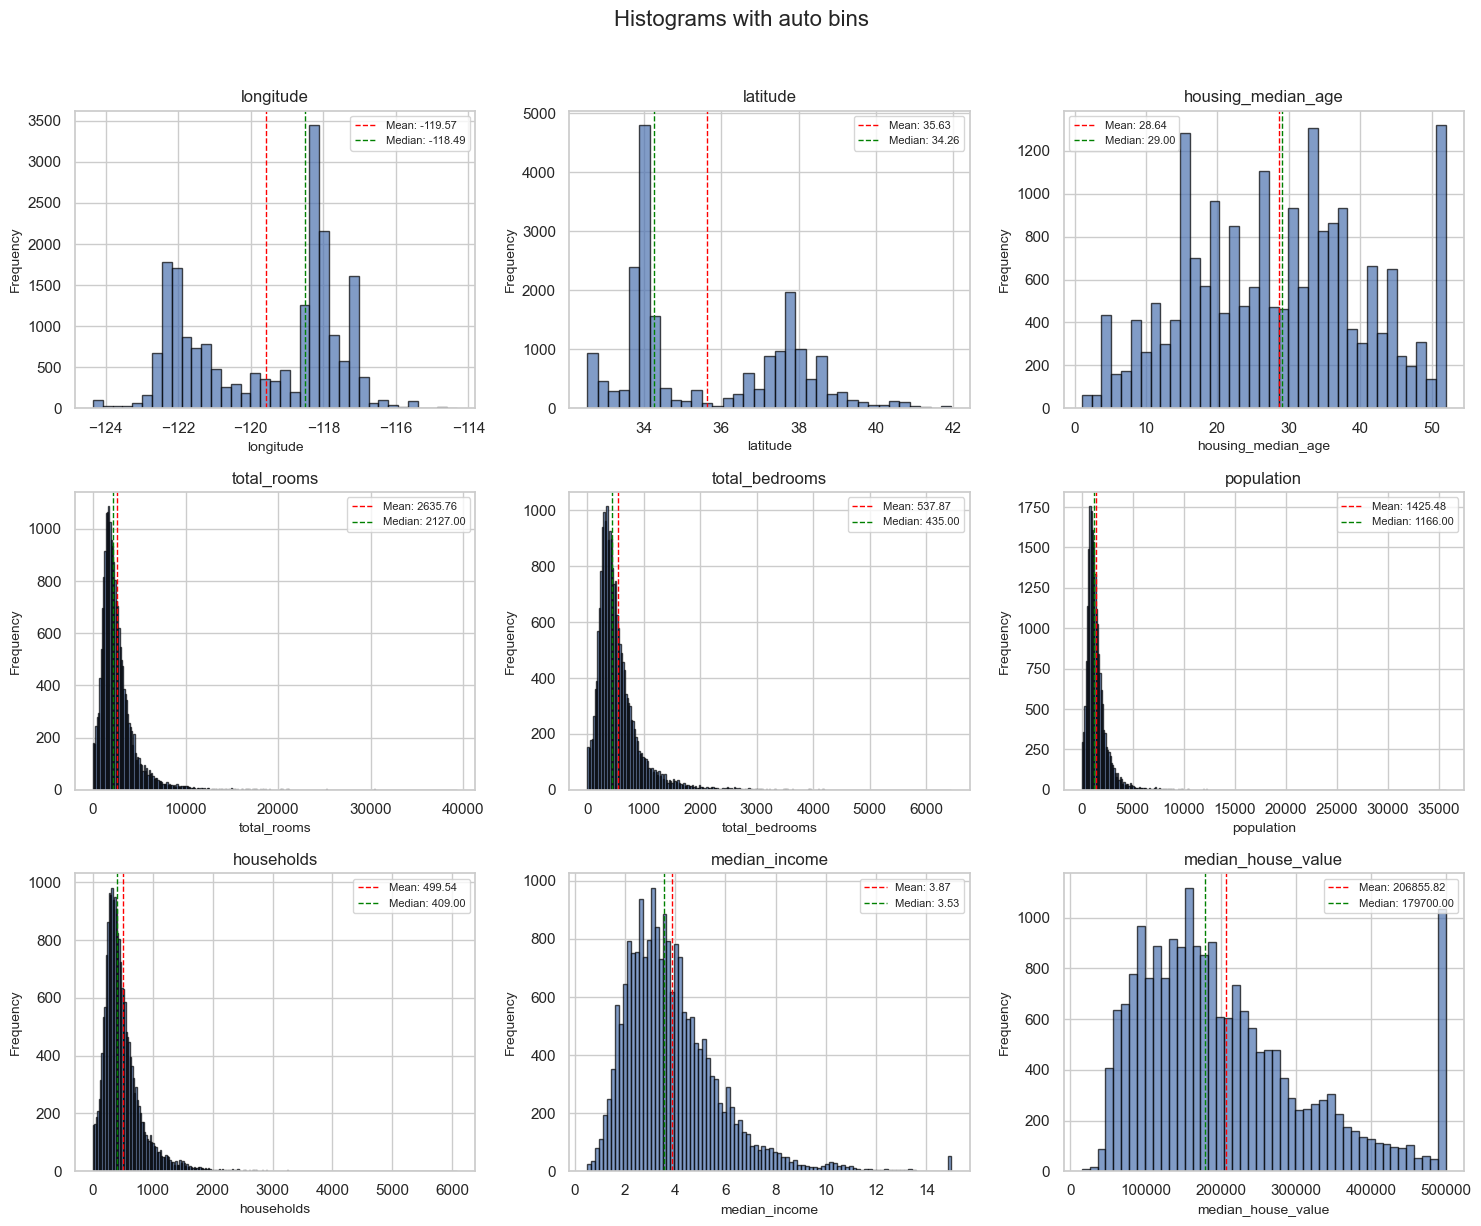

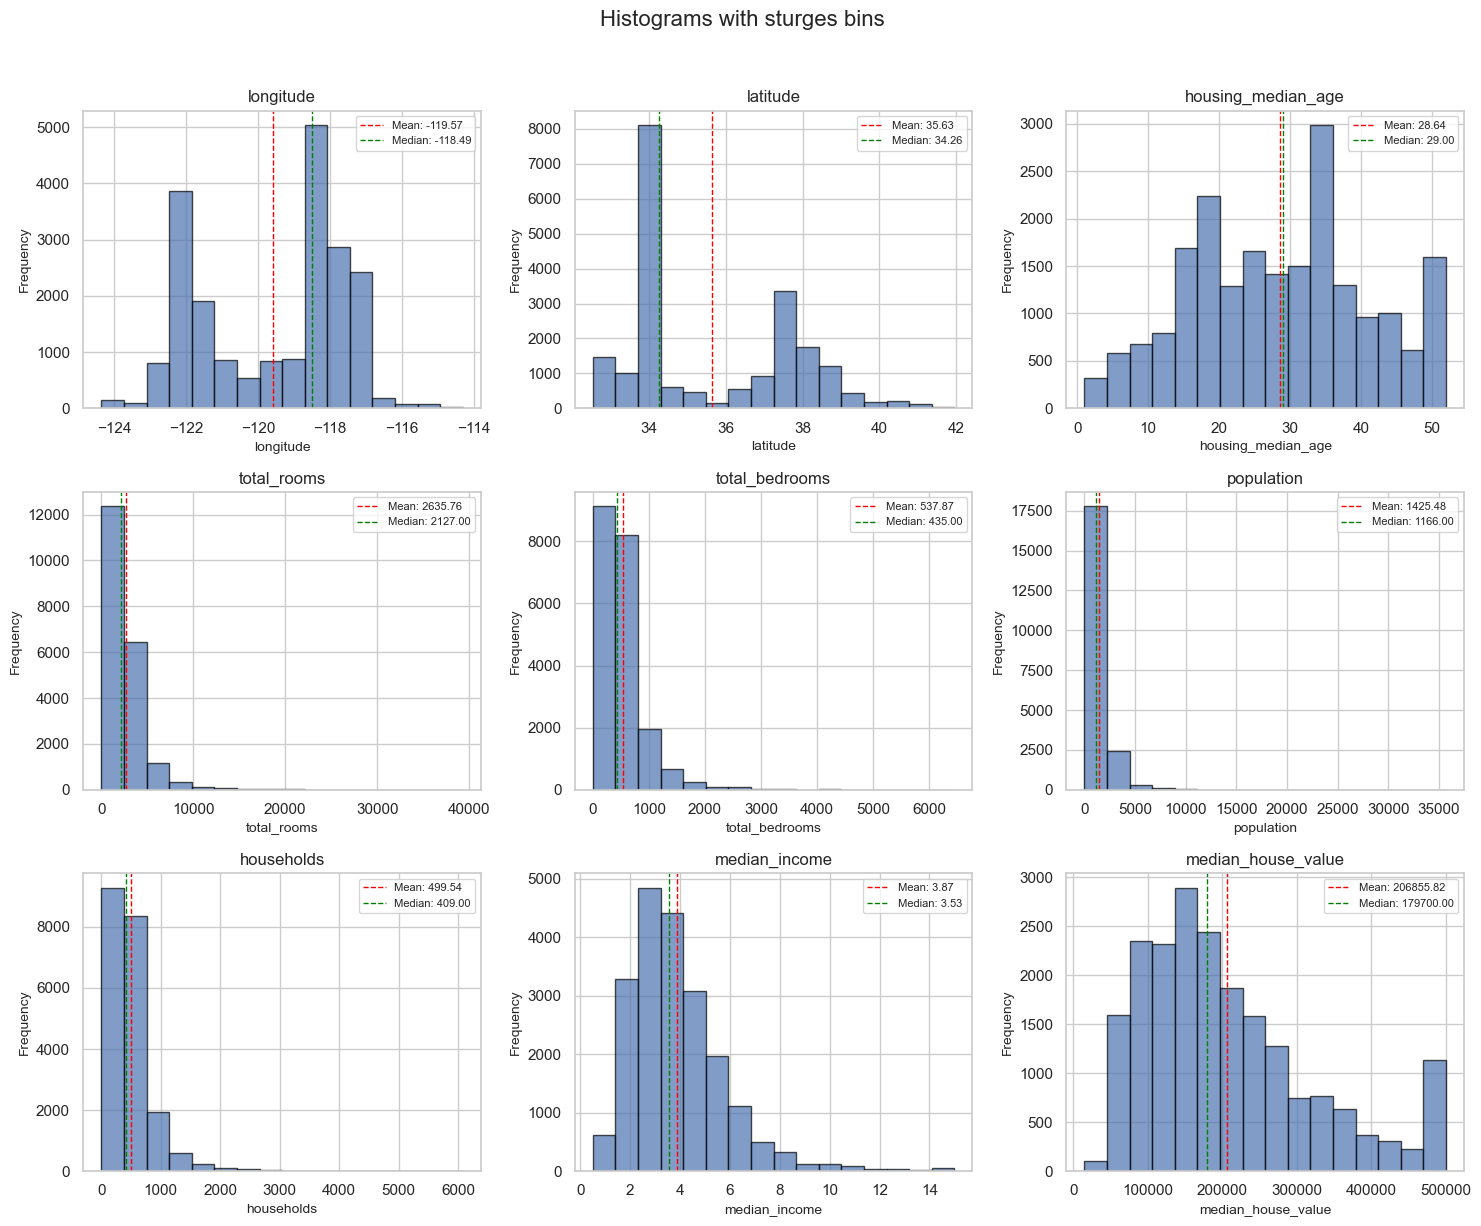

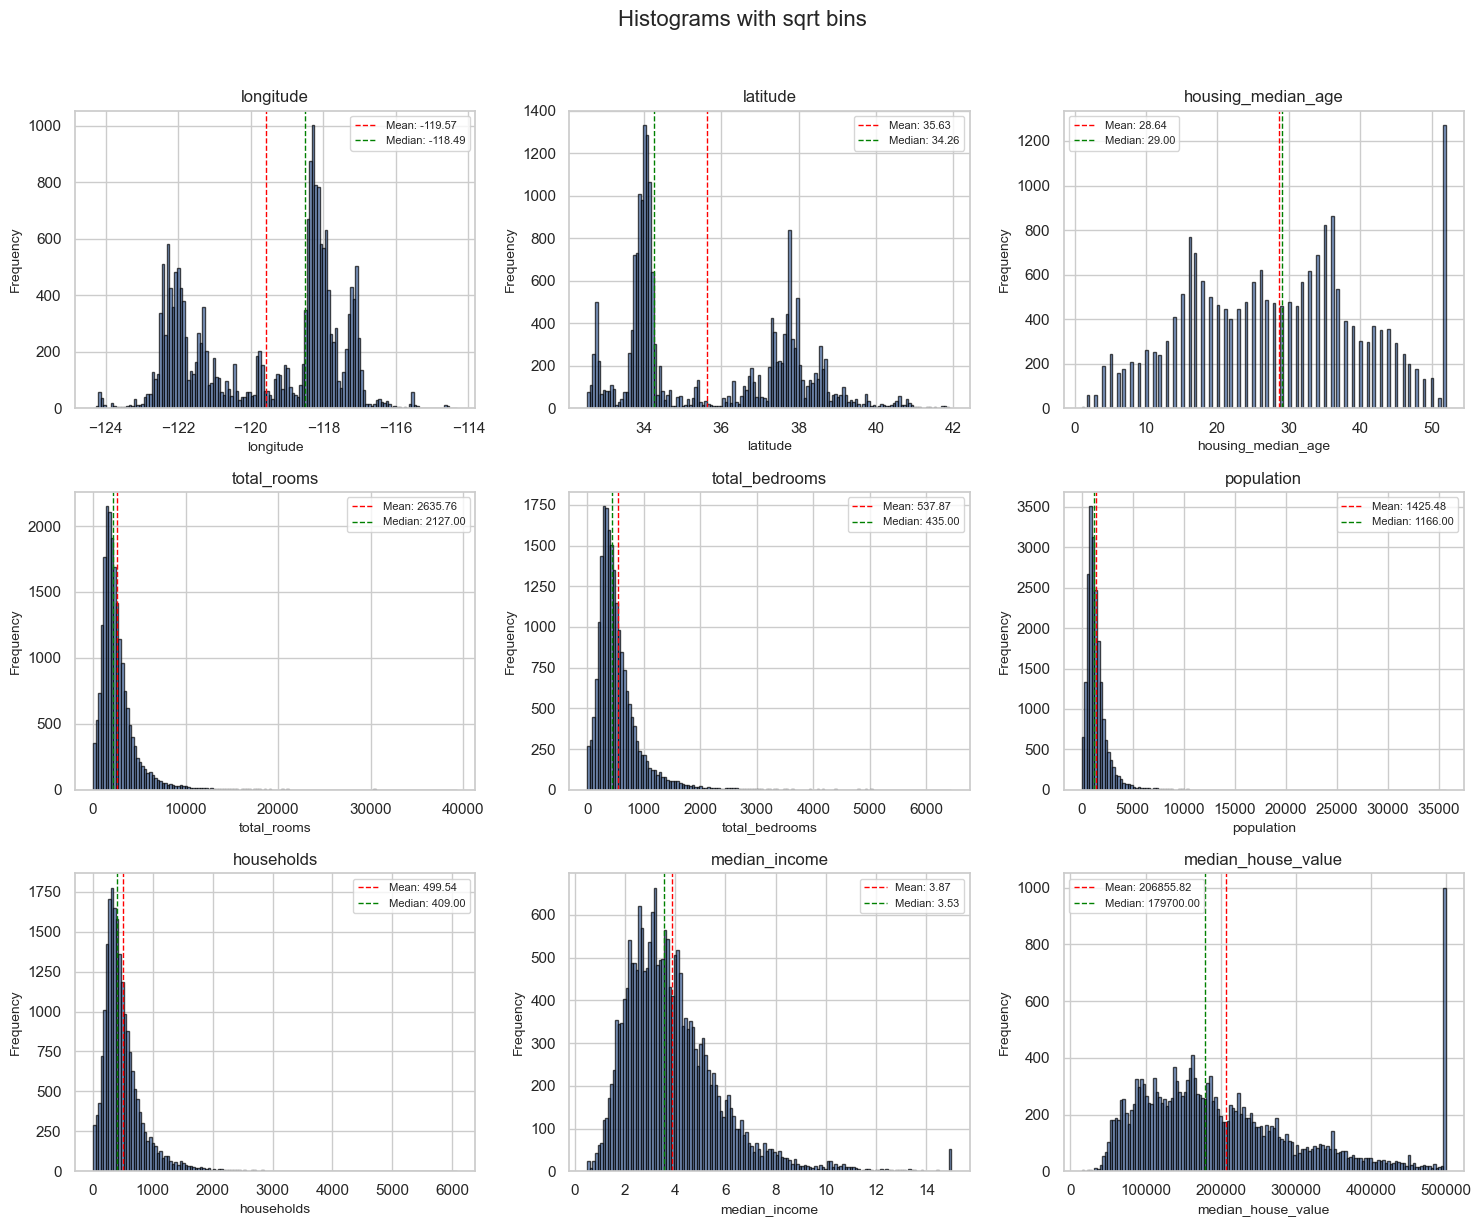

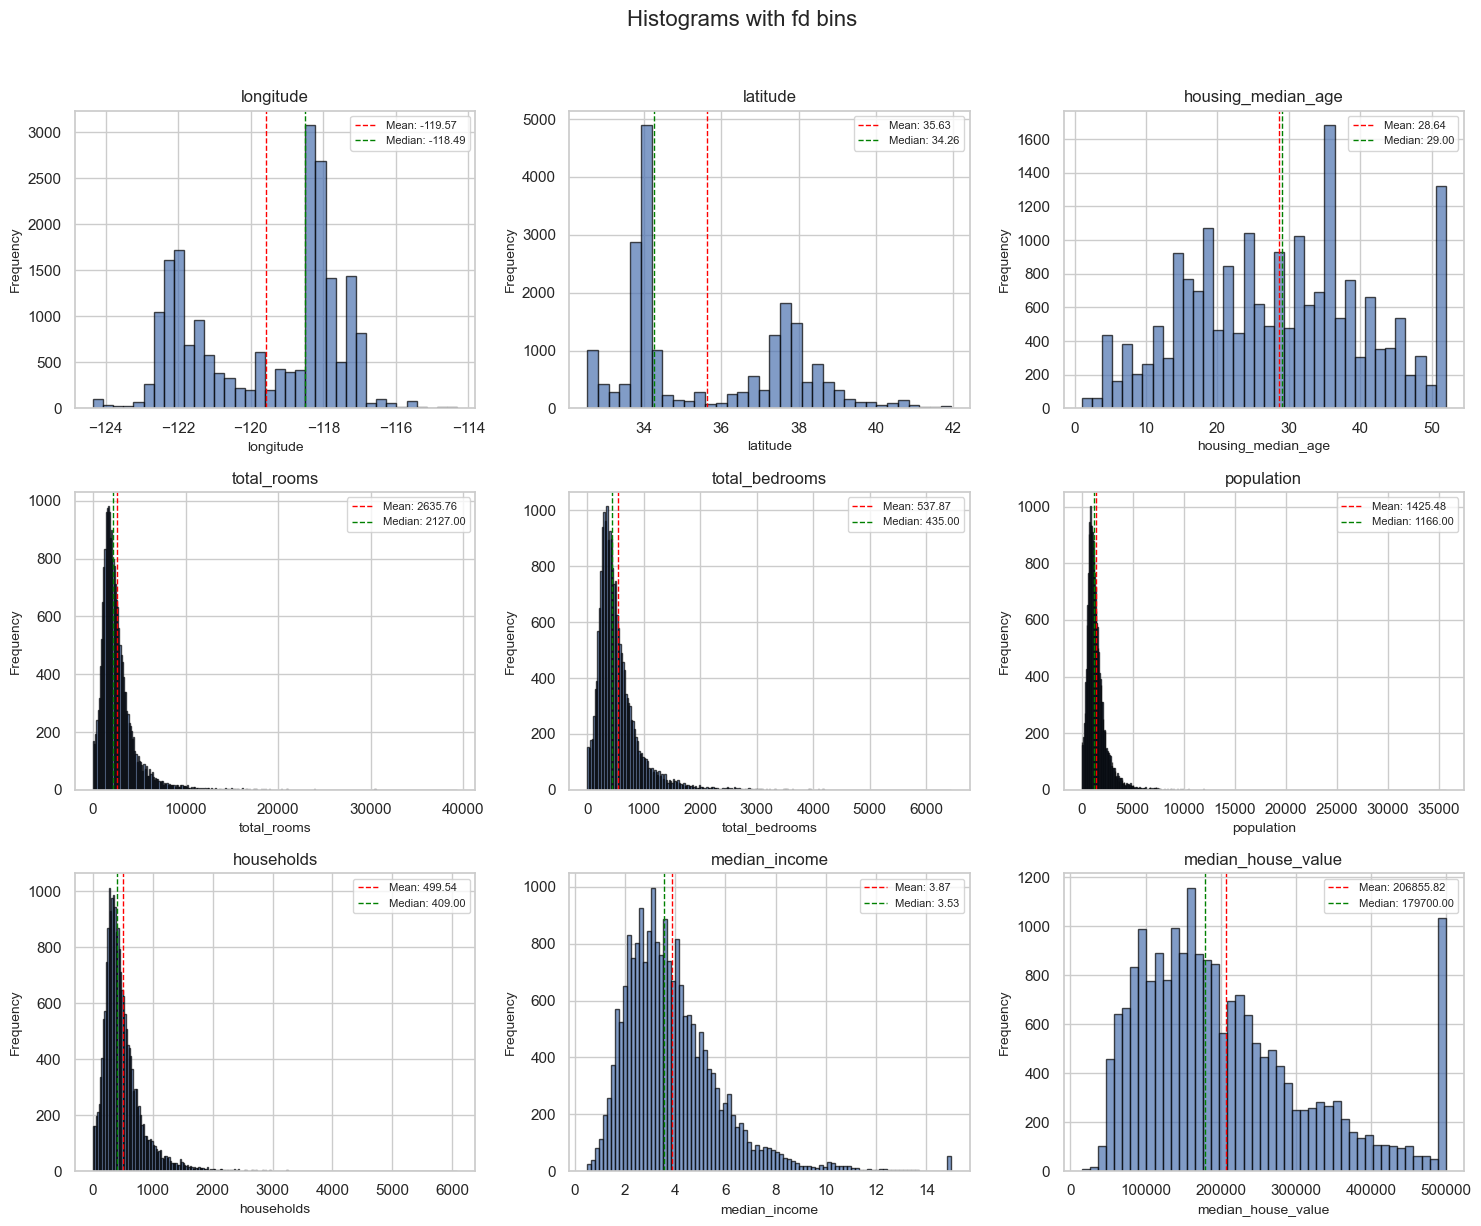

KeyError: 'MedInc'

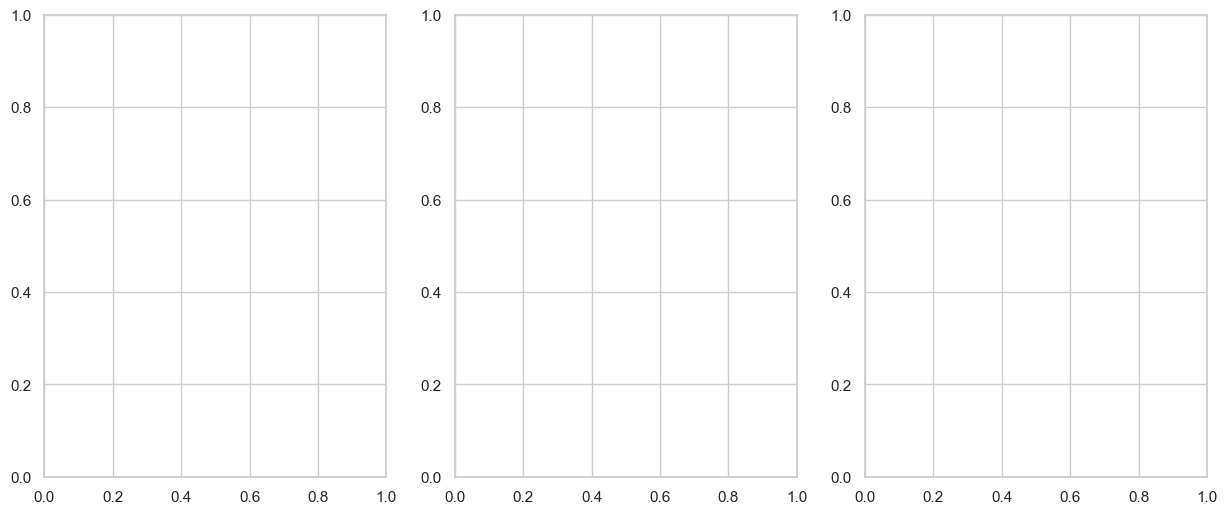

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visuals
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# 1. Plot histograms for all numeric columns with different bins
def plot_histograms_with_bins(df, numeric_cols):
    """
    Plot histograms for all numeric columns with different bin settings.
    
    Parameters:
    df: DataFrame containing the data
    numeric_cols: List of numeric column names
    """
    n_cols = 3
    n_rows = int(np.ceil(len(numeric_cols) / n_cols))
    
    # Different bin strategies to try
    bin_strategies = ['auto', 'sturges', 'sqrt', 'fd']  # fd = Freedman-Diaconis
    
    for bin_method in bin_strategies:
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
        fig.suptitle(f'Histograms with {bin_method} bins', fontsize=16, y=1.02)
        
        axes = axes.flatten() if n_rows > 1 else axes
        
        for i, col in enumerate(numeric_cols):
            if i < len(axes):
                ax = axes[i]
                
                # Calculate bins based on method
                if bin_method == 'auto':
                    bins = 'auto'
                elif bin_method == 'sturges':
                    bins = int(np.ceil(np.log2(len(df))) + 1)
                elif bin_method == 'sqrt':
                    bins = int(np.sqrt(len(df)))
                elif bin_method == 'fd':
                    # Freedman-Diaconis rule
                    q75, q25 = np.percentile(df[col].dropna(), [75, 25])
                    iqr = q75 - q25
                    if iqr == 0:
                        bins = 'auto'
                    else:
                        bin_width = 2 * iqr / (len(df) ** (1/3))
                        bins = int((df[col].max() - df[col].min()) / bin_width)
                
                # Plot histogram
                df[col].dropna().hist(bins=bins, ax=ax, edgecolor='black', alpha=0.7)
                
                # Add labels and title
                ax.set_title(f'{col}', fontsize=12)
                ax.set_xlabel(col, fontsize=10)
                ax.set_ylabel('Frequency', fontsize=10)
                
                # Add mean and median lines
                mean_val = df[col].mean()
                median_val = df[col].median()
                ax.axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean_val:.2f}')
                ax.axvline(median_val, color='green', linestyle='--', linewidth=1, label=f'Median: {median_val:.2f}')
                ax.legend(fontsize=8)
        
        # Hide empty subplots
        for i in range(len(numeric_cols), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()

# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Plot histograms with different bins
plot_histograms_with_bins(df, numeric_cols)

# 2. Methods to eliminate skewness of column features
"""
MOST WIDELY USED METHODS TO ELIMINATE SKEWNESS:

1. LOG TRANSFORMATION (for right-skewed data):
   - Formula: x' = log(x + 1)  # +1 to handle zeros
   - Best for: Positive data with right skew
   - Python: np.log1p(x)

2. SQUARE ROOT TRANSFORMATION:
   - Formula: x' = sqrt(x)
   - Best for: Moderate right skew, count data
   - Python: np.sqrt(x)

3. BOX-COX TRANSFORMATION (for positive values):
   - Finds optimal lambda parameter
   - Formula: x' = (x^λ - 1)/λ if λ ≠ 0, else log(x)
   - Python: from scipy import stats; stats.boxcox(x)

4. YEO-JOHNSON TRANSFORMATION (for any values, including negative):
   - More flexible than Box-Cox
   - Python: stats.yeojohnson(x)

5. RECIPROCAL TRANSFORMATION:
   - Formula: x' = 1/x
   - Best for: Very strong right skew
   - Caution: Changes order of values

6. POWER TRANSFORMATIONS:
   - Cubic: x^3 (for left skew)
   - Square: x^2 (for left skew)
   - Cube root: x^(1/3) (for right skew)

7. QUANTILE TRANSFORMATION:
   - Maps to normal distribution
   - Python: from sklearn.preprocessing import QuantileTransformer

8. WINSORIZATION (for outliers):
   - Cap extreme values at certain percentiles
   - Example: Cap at 1st and 99th percentiles

Note: Always check transformation results with QQ-plots or skewness tests.
"""

# 3. Box plots for specific features to detect outliers
def plot_boxplots_for_features(df, features):
    """
    Plot box plots for specified features to detect outliers.
    
    Parameters:
    df: DataFrame containing the data
    features: List of feature names to plot
    """
    n_features = len(features)
    fig, axes = plt.subplots(1, n_features, figsize=(5*n_features, 6))
    
    if n_features == 1:
        axes = [axes]
    
    for i, feature in enumerate(features):
        ax = axes[i]
        
        # Create box plot
        bp = ax.boxplot(df[feature].dropna(), patch_artist=True, 
                       boxprops=dict(facecolor='lightblue'),
                       medianprops=dict(color='red', linewidth=2),
                       whiskerprops=dict(color='black'),
                       capprops=dict(color='black'),
                       flierprops=dict(marker='o', color='red', alpha=0.5))
        
        # Add labels and title
        ax.set_title(f'Box Plot of {feature}', fontsize=14)
        ax.set_ylabel('Values', fontsize=12)
        ax.set_xlabel(feature, fontsize=12)
        
        # Add grid for better readability
        ax.grid(True, alpha=0.3)
        
        # Calculate and display outlier count
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)][feature]
        
        # Add text with outlier information
        ax.text(0.05, 0.95, f'Outliers: {len(outliers)}\n({len(outliers)/len(df)*100:.1f}%)',
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Specify the features you mentioned
features_to_check = ['MedInc', 'AveRooms', 'Population']  # Adjust these names based on your actual column names

# Plot box plots
plot_boxplots_for_features(df, features_to_check)

# 4. Correlation Heatmap
def plot_correlation_heatmap(df, numeric_cols):
    """
    Plot correlation heatmap for numeric columns.
    
    Parameters:
    df: DataFrame containing the data
    numeric_cols: List of numeric column names
    """
    # Calculate correlation matrix
    correlation_matrix = df[numeric_cols].corr()
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Plot heatmap
    plt.figure(figsize=(12, 10))
    
    # Create heatmap with annotations
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.2f',
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": 0.8})
    
    plt.title('Correlation Heatmap of Numeric Features', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    # Print highly correlated pairs (absolute correlation > 0.7)
    print("Highly Correlated Feature Pairs (|correlation| > 0.7):")
    print("-" * 50)
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > 0.7:
                col1 = correlation_matrix.columns[i]
                col2 = correlation_matrix.columns[j]
                print(f"{col1} & {col2}: {corr_value:.3f}")

# Plot correlation heatmap
plot_correlation_heatmap(df, numeric_cols)

# Additional: Skewness analysis before and after transformation (example)
print("\nSkewness Analysis:")
print("-" * 50)
for col in numeric_cols:
    skewness = df[col].skew()
    skew_type = "Right skewed" if skewness > 0 else "Left skewed" if skewness < 0 else "Symmetric"
    print(f"{col}: Skewness = {skewness:.3f} ({skew_type})")
    
    # Suggest transformation based on skewness
    if abs(skewness) > 0.5:  # Moderate to high skewness
        if skewness > 0:
            print(f"  → Suggest: Log or Square Root transformation")
        else:
            print(f"  → Suggest: Power transformation (square or cube)")
            

Available columns in DataFrame:
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']


Longitude column: longitude
Latitude column: latitude
Price column: median_house_value
Population column: population


Plotting 20640 valid data points


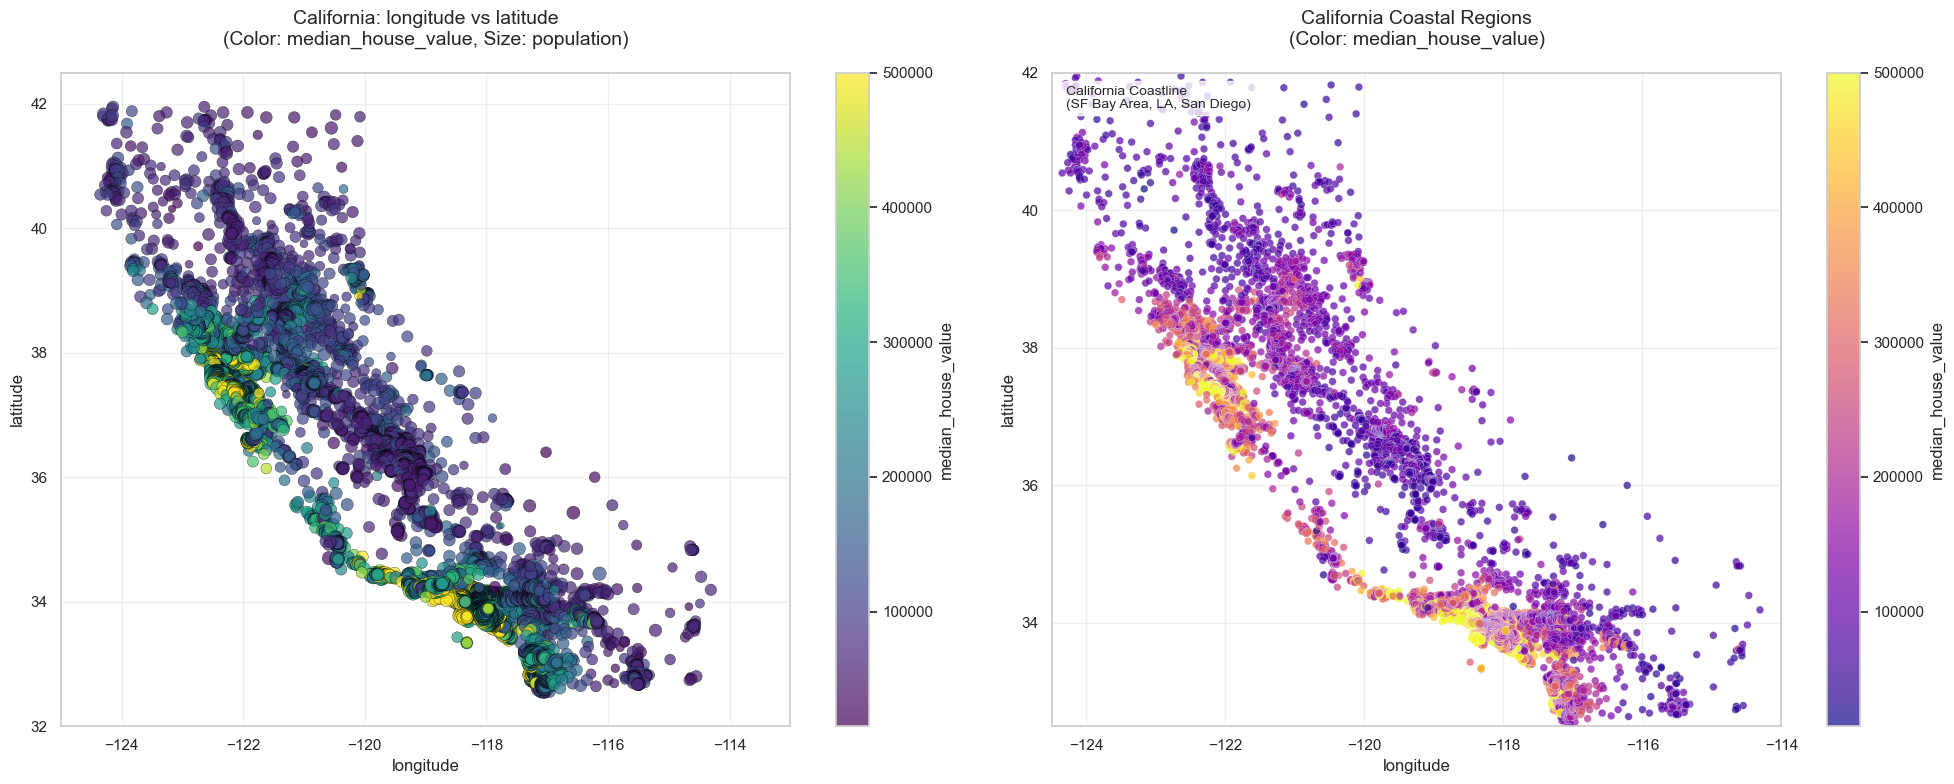


Geographic Data Statistics:
Longitude range: -124.35 to -114.31
Latitude range: 32.54 to 41.95

median_house_value statistics:
  Min: $14,999
  Max: $500,001
  Mean: $206,856
  Median: $179,700

population statistics:
  Min: 3
  Max: 35,682
  Mean: 1,425
  Median: 1,166


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visuals
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 10)

# First, let's check what columns we actually have
print("Available columns in DataFrame:")
print(df.columns.tolist())
print("\n" + "="*50 + "\n")

# 1. Identify the correct column names
# Common variations for California housing dataset
def find_column(df, possible_names):
    """
    Find a column by checking multiple possible names
    """
    for name in possible_names:
        if name in df.columns:
            return name
    
    # Try case-insensitive
    for col in df.columns:
        for name in possible_names:
            if name.lower() in col.lower():
                return col
    
    return None

# Find the actual column names
longitude_col = find_column(df, ['longitude', 'Longitude', 'LONGITUDE', 'lon'])
latitude_col = find_column(df, ['latitude', 'Latitude', 'LATITUDE', 'lat'])
price_col = find_column(df, ['medianHouseValue', 'MedHouseVal', 'median_house_value', 'MedInc', 'median_income', 'target'])
population_col = find_column(df, ['population', 'Population', 'POPULATION', 'total_population'])

print(f"Longitude column: {longitude_col}")
print(f"Latitude column: {latitude_col}")
print(f"Price column: {price_col}")
print(f"Population column: {population_col}")
print("\n" + "="*50 + "\n")

# Check if we found all necessary columns
required_cols_found = all([longitude_col, latitude_col, price_col, population_col])
if not required_cols_found:
    print("WARNING: Not all required columns found!")
    print("Creating plot with available columns...\n")

# 2. Create the scatter plot
def create_california_housing_plot(df, lon_col, lat_col, price_col, pop_col):
    """
    Create a scatter plot of California housing data
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Prepare data
    x = df[lon_col]
    y = df[lat_col]
    
    # Create a mask for valid data (remove NaNs for plotting)
    mask = x.notna() & y.notna()
    if price_col:
        mask = mask & df[price_col].notna()
    if pop_col:
        mask = mask & df[pop_col].notna()
    
    x_clean = x[mask]
    y_clean = y[mask]
    
    print(f"Plotting {len(x_clean)} valid data points")
    
    # SUBPLOT 1: Longitude vs Latitude (basic geographic plot)
    ax1 = axes[0]
    
    if price_col and pop_col:
        # Color by price, size by population
        colors = df.loc[mask, price_col]
        sizes = df.loc[mask, pop_col]
        
        # Normalize sizes for better visualization
        # Using log scale for population (since it can vary greatly)
        sizes_normalized = np.log1p(sizes) * 10  # log(1 + x) to handle zeros
        
        scatter1 = ax1.scatter(
            x=x_clean,
            y=y_clean,
            c=colors,
            s=sizes_normalized,
            cmap='viridis',
            alpha=0.7,
            edgecolor='black',
            linewidth=0.3
        )
        
        # Add colorbar
        cbar1 = plt.colorbar(scatter1, ax=ax1)
        cbar1.set_label(f'{price_col}', fontsize=12)
        
        # Add title with actual column names
        ax1.set_title(f'California: {lon_col} vs {lat_col}\n(Color: {price_col}, Size: {pop_col})', 
                     fontsize=14, pad=20)
        
    else:
        # Simple scatter plot if we don't have price or population
        scatter1 = ax1.scatter(
            x=x_clean,
            y=y_clean,
            alpha=0.6,
            color='blue',
            s=20
        )
        ax1.set_title(f'California: {lon_col} vs {lat_col}', fontsize=14, pad=20)
    
    ax1.set_xlabel(lon_col, fontsize=12)
    ax1.set_ylabel(lat_col, fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Add California coastline approximation
    # California approximate boundaries: 
    # Longitude: -124 to -114, Latitude: 32 to 42
    ax1.set_xlim(-125, -113)  # Slightly wider than actual CA
    ax1.set_ylim(32, 42.5)
    
    # SUBPLOT 2: Focus on coastal regions (where most population is)
    ax2 = axes[1]
    
    if price_col:
        # Use a different colormap for better contrast
        scatter2 = ax2.scatter(
            x=x_clean,
            y=y_clean,
            c=df.loc[mask, price_col] if price_col else 'blue',
            s=30,  # Fixed size for clarity
            cmap='plasma',
            alpha=0.7,
            edgecolor='white',
            linewidth=0.2
        )
        
        # Add colorbar
        cbar2 = plt.colorbar(scatter2, ax=ax2)
        cbar2.set_label(f'{price_col}', fontsize=12)
        
        ax2.set_title(f'California Coastal Regions\n(Color: {price_col})', 
                     fontsize=14, pad=20)
    else:
        ax2.scatter(
            x=x_clean,
            y=y_clean,
            alpha=0.6,
            color='red',
            s=20
        )
        ax2.set_title(f'California Coastal Regions', fontsize=14, pad=20)
    
    ax2.set_xlabel(lon_col, fontsize=12)
    ax2.set_ylabel(lat_col, fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Zoom into coastal California
    ax2.set_xlim(-124.5, -114)
    ax2.set_ylim(32.5, 42)
    
    # Add text annotation about California geography
    ax2.text(0.02, 0.98, 'California Coastline\n(SF Bay Area, LA, San Diego)', 
            transform=ax2.transAxes,
            fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # 3. Print some statistics about the geographic data
    print("\nGeographic Data Statistics:")
    print("="*50)
    print(f"Longitude range: {x.min():.2f} to {x.max():.2f}")
    print(f"Latitude range: {y.min():.2f} to {y.max():.2f}")
    
    if price_col:
        print(f"\n{price_col} statistics:")
        print(f"  Min: ${df[price_col].min():,.0f}")
        print(f"  Max: ${df[price_col].max():,.0f}")
        print(f"  Mean: ${df[price_col].mean():,.0f}")
        print(f"  Median: ${df[price_col].median():,.0f}")
    
    if pop_col:
        print(f"\n{pop_col} statistics:")
        print(f"  Min: {df[pop_col].min():,.0f}")
        print(f"  Max: {df[pop_col].max():,.0f}")
        print(f"  Mean: {df[pop_col].mean():,.0f}")
        print(f"  Median: {df[pop_col].median():,.0f}")

# 3. Execute the plotting
if longitude_col and latitude_col:
    create_california_housing_plot(df, longitude_col, latitude_col, price_col, population_col)
else:
    print("ERROR: Could not find longitude and latitude columns!")
    print("Please check your DataFrame columns and adjust the find_column() function.")
    
    # Try a simple scatter plot with the first two numeric columns as fallback
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) >= 2:
        print(f"\nTrying with first two numeric columns: {numeric_cols[0]} vs {numeric_cols[1]}")
        
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.scatter(df[numeric_cols[0]], df[numeric_cols[1]], alpha=0.6, s=20)
        ax.set_xlabel(numeric_cols[0])
        ax.set_ylabel(numeric_cols[1])
        ax.set_title(f'Scatter Plot: {numeric_cols[0]} vs {numeric_cols[1]}')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

DATA PREPARATION
Available columns:
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']

Features for modeling: ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Target variable: median_house_value
Number of features: 7

PRINCIPAL COMPONENT ANALYSIS (PCA)
Missing values found. Filling with median...
Components needed for 85% variance: 3
Components needed for 95% variance: 4


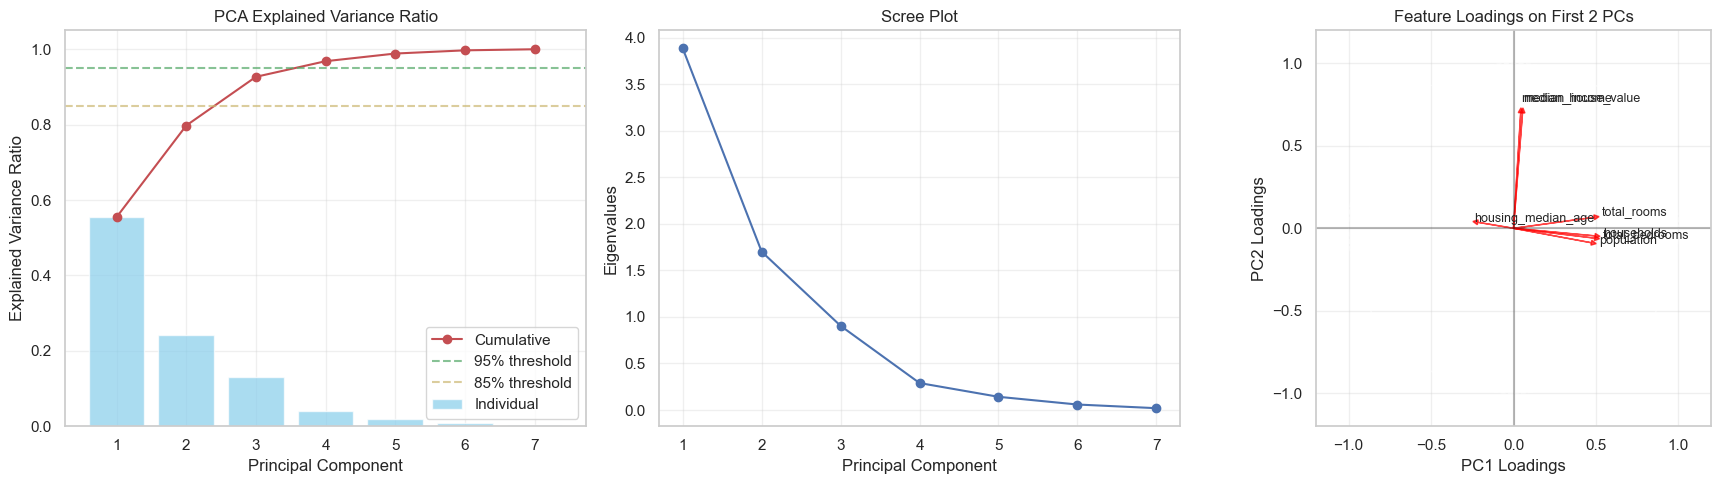


PC1 vs PC2 SCATTER PLOT


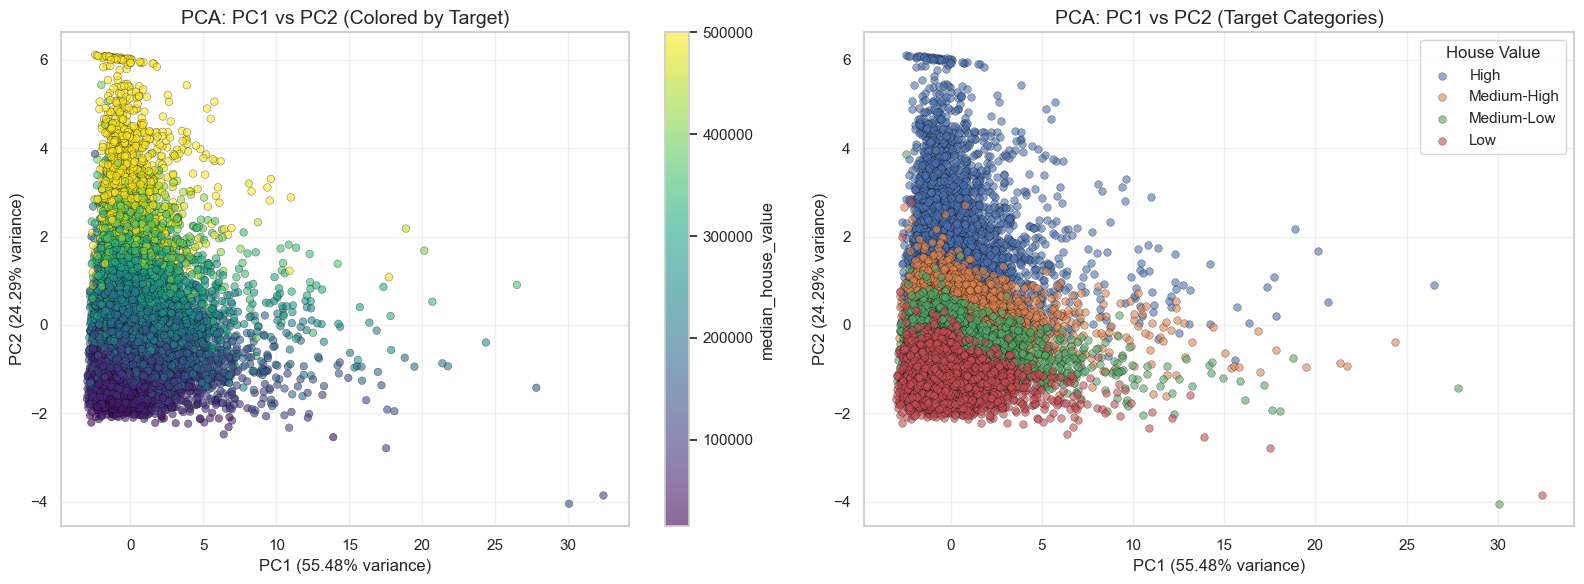


PCA Components (Top 2):
PC1 explains 55.48% of variance
PC2 explains 24.29% of variance
Total variance explained by PC1+PC2: 79.77%

Top features contributing to PC1:
households           0.4945
total_bedrooms       0.4919
total_rooms          0.4889
population           0.4719
housing_median_age   0.2168
dtype: float64

Top features contributing to PC2:
median_house_value   0.7005
median_income        0.7001
population           0.0876
total_rooms          0.0667
total_bedrooms       0.0597
dtype: float64

CORRELATION ANALYSIS


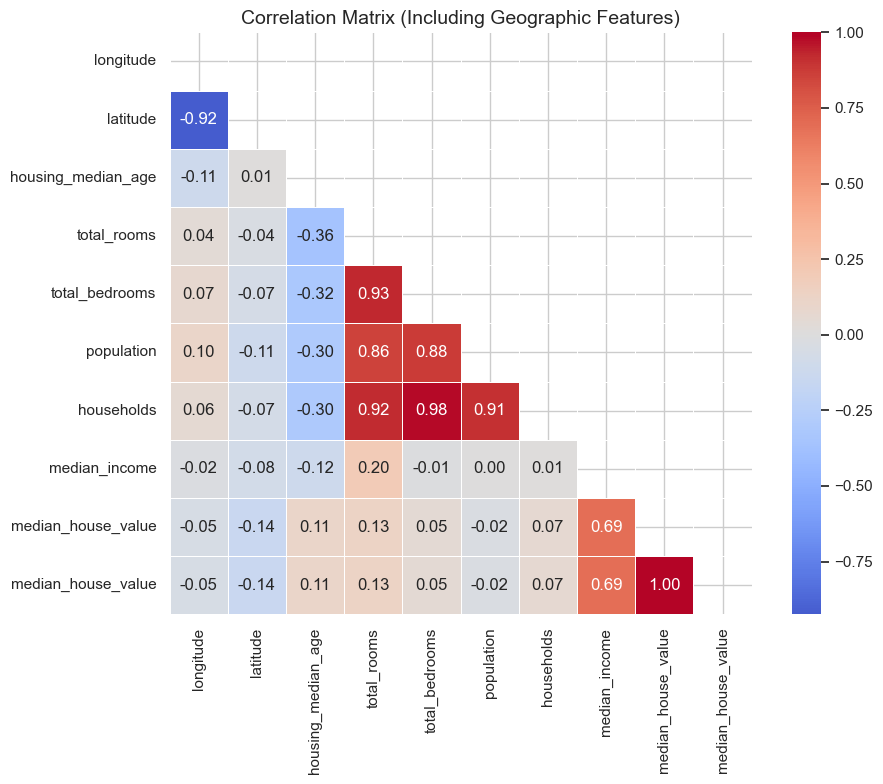


Correlation with target variable:


TypeError: unsupported format string passed to Series.__format__

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

# Set style for better visuals
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# 1. First, identify and prepare features
print("="*60)
print("DATA PREPARATION")
print("="*60)

# Check available columns
print("Available columns:")
print(df.columns.tolist())

# Identify numeric columns (excluding target and geographic columns)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Common California housing dataset features (adjust based on your actual columns)
# Remove geographic columns and target variable
exclude_cols = ['longitude', 'latitude', 'medianHouseValue', 'MedHouseVal', 'target', 'Price']
features = [col for col in numeric_cols if col not in exclude_cols]

# Find target column
target_candidates = ['medianHouseValue', 'MedHouseVal', 'target', 'Price', 'median_house_value']
target_col = None
for col in target_candidates:
    if col in df.columns:
        target_col = col
        break

if not target_col:
    # Try to find any column that might be the target (last column often)
    target_col = df.columns[-1]

print(f"\nFeatures for modeling: {features}")
print(f"Target variable: {target_col}")
print(f"Number of features: {len(features)}")

# 2. PCA Analysis
print("\n" + "="*60)
print("PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("="*60)

# Prepare data for PCA
X = df[features].copy()

# Handle missing values
if X.isnull().sum().sum() > 0:
    print(f"Missing values found. Filling with median...")
    X = X.fillna(X.median())

# Standardize features (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance ratio
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Subplot 1: Explained variance ratio
ax1 = axes[0]
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

ax1.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='skyblue', label='Individual')
ax1.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'r-', marker='o', label='Cumulative')
ax1.axhline(y=0.95, color='g', linestyle='--', alpha=0.7, label='95% threshold')
ax1.axhline(y=0.85, color='y', linestyle='--', alpha=0.7, label='85% threshold')

ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('PCA Explained Variance Ratio')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_85 = np.argmax(cumulative_variance >= 0.85) + 1
print(f"Components needed for 85% variance: {n_components_85}")
print(f"Components needed for 95% variance: {n_components_95}")

# Subplot 2: Scree plot
ax2 = axes[1]
ax2.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_, 'b-o')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Eigenvalues')
ax2.set_title('Scree Plot')
ax2.grid(True, alpha=0.3)

# Subplot 3: Feature loadings for first 2 PCs
ax3 = axes[2]
# Get loadings for first 2 components
loadings = pca.components_[:2].T

# Create a DataFrame for better visualization
loadings_df = pd.DataFrame(loadings, index=features, columns=['PC1', 'PC2'])

# Plot loadings
for i, feature in enumerate(features):
    ax3.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
              head_width=0.03, head_length=0.03, fc='red', ec='red', alpha=0.7)
    ax3.text(loadings[i, 0]*1.1, loadings[i, 1]*1.1, feature, fontsize=9)

# Draw unit circle
circle = plt.Circle((0, 0), 1, fill=False, linestyle='--', alpha=0.5)
ax3.add_artist(circle)

ax3.set_xlim(-1.2, 1.2)
ax3.set_ylim(-1.2, 1.2)
ax3.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax3.axvline(x=0, color='k', linestyle='-', alpha=0.3)
ax3.set_xlabel('PC1 Loadings')
ax3.set_ylabel('PC2 Loadings')
ax3.set_title('Feature Loadings on First 2 PCs')
ax3.grid(True, alpha=0.3)
ax3.set_aspect('equal')

plt.tight_layout()
plt.show()

# 3. Scatter plot: PC1 vs PC2 colored by target
print("\n" + "="*60)
print("PC1 vs PC2 SCATTER PLOT")
print("="*60)

# Choose top 2 principal components
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame({
    'PC1': X_pca_2d[:, 0],
    'PC2': X_pca_2d[:, 1],
    'Target': df[target_col]
})

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Colored by target value
ax1 = axes[0]
scatter1 = ax1.scatter(pca_df['PC1'], pca_df['PC2'], 
                       c=pca_df['Target'], cmap='viridis', 
                       alpha=0.6, s=30, edgecolor='black', linewidth=0.3)
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label(target_col, fontsize=12)

ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
ax1.set_title('PCA: PC1 vs PC2 (Colored by Target)', fontsize=14)
ax1.grid(True, alpha=0.3)

# Subplot 2: With clusters (using quantiles)
ax2 = axes[1]
# Create categories based on target quantiles
pca_df['Target_Category'] = pd.qcut(pca_df['Target'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

# Define colors for categories
category_colors = {'Low': 'blue', 'Medium-Low': 'green', 'Medium-High': 'orange', 'High': 'red'}

for category in pca_df['Target_Category'].unique():
    subset = pca_df[pca_df['Target_Category'] == category]
    ax2.scatter(subset['PC1'], subset['PC2'], 
                label=category, alpha=0.6, s=30, 
                edgecolor='black', linewidth=0.3)

ax2.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
ax2.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
ax2.set_title('PCA: PC1 vs PC2 (Target Categories)', fontsize=14)
ax2.legend(title='House Value')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print PCA information
print(f"\nPCA Components (Top 2):")
print(f"PC1 explains {pca_2d.explained_variance_ratio_[0]:.2%} of variance")
print(f"PC2 explains {pca_2d.explained_variance_ratio_[1]:.2%} of variance")
print(f"Total variance explained by PC1+PC2: {sum(pca_2d.explained_variance_ratio_):.2%}")

# Show feature contributions to PCs
print("\nTop features contributing to PC1:")
pc1_loadings = pd.Series(pca_2d.components_[0], index=features)
print(pc1_loadings.abs().sort_values(ascending=False).head(5))

print("\nTop features contributing to PC2:")
pc2_loadings = pd.Series(pca_2d.components_[1], index=features)
print(pc2_loadings.abs().sort_values(ascending=False).head(5))

# 4. Correlation Analysis (proving latitude/longitude exclusion)
print("\n" + "="*60)
print("CORRELATION ANALYSIS")
print("="*60)

# Check if geographic columns exist
geo_cols = ['longitude', 'latitude']
existing_geo_cols = [col for col in geo_cols if col in df.columns]

if existing_geo_cols:
    # Calculate correlation matrix
    all_cols = existing_geo_cols + features + [target_col]
    correlation_matrix = df[all_cols].corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', 
                center=0, fmt='.2f', square=True, linewidths=0.5)
    plt.title(f'Correlation Matrix (Including Geographic Features)', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Print specific correlations with target
    print("\nCorrelation with target variable:")
    for geo_col in existing_geo_cols:
        if geo_col in correlation_matrix.columns and target_col in correlation_matrix.columns:
            corr = correlation_matrix.loc[geo_col, target_col]
            print(f"{geo_col} correlation with {target_col}: {corr:.4f}")
            if abs(corr) < 0.1:
                print(f"  → Very weak correlation (|r| < 0.1), can be excluded from linear model")
            elif abs(corr) < 0.3:
                print(f"  → Weak correlation (|r| < 0.3), may not be useful in linear model")
else:
    print("Geographic columns not found in dataset.")

# 5. Create and Evaluate Pipeline
print("\n" + "="*60)
print("MULTIPLE LINEAR REGRESSION PIPELINE")
print("="*60)

# Split data (excluding geographic features)
X = df[features].copy()
y = df[target_col].copy()

# Handle missing values
X = X.fillna(X.median())

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

# Create pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('regressor', LinearRegression())  # Linear regression
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# 6. Extract and display coefficients
print("\n" + "="*60)
print("MODEL COEFFICIENTS")
print("="*60)

# Get coefficients from the pipeline
scaler = pipeline.named_steps['scaler']
regressor = pipeline.named_steps['regressor']

# Create coefficient DataFrame (scaled back to original feature scale)
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': regressor.coef_,
    'Abs_Coefficient': np.abs(regressor.coef_)
})

# Sort by absolute coefficient value
coefficients_sorted = coefficients.sort_values('Abs_Coefficient', ascending=False)

print("Feature coefficients (sorted by importance):")
print(coefficients_sorted.to_string(index=False))

print(f"\nIntercept: {regressor.intercept_:.4f}")

# 7. Model Evaluation
print("\n" + "="*60)
print("MODEL EVALUATION METRICS")
print("="*60)

# Calculate metrics
def calculate_metrics(y_true, y_pred, n_features, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Adjusted R² calculation
    n = len(y_true)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    
    return {
        'Dataset': dataset_name,
        'MSE': mse,
        'RMSE': np.sqrt(mse),
        'MAE': mae,
        'R²': r2,
        'Adjusted R²': adj_r2,
        'n_samples': n,
        'n_features': n_features
    }

train_metrics = calculate_metrics(y_train, y_train_pred, len(features), 'Training')
test_metrics = calculate_metrics(y_test, y_test_pred, len(features), 'Test')

metrics_df = pd.DataFrame([train_metrics, test_metrics])
print(metrics_df.to_string(index=False))

# 8. Answer conceptual questions
print("\n" + "="*60)
print("CONCEPTUAL QUESTIONS")
print("="*60)

print("\nQ: Is high R² score always good?")
print("A: No, high R² is not always good. Reasons:")
print("   1. Overfitting: High R² on training but low on test indicates overfitting")
print("   2. Irrelevant predictors: Adding more features always increases R², even if irrelevant")
print("   3. Non-linear relationships: R² assumes linearity, may miss complex patterns")
print("   4. Outliers: R² can be inflated by outliers")
print("   5. Always check Adjusted R² for multiple regression with many features")

print("\nQ: Is low training loss always preferred?")
print("A: No, low training loss is not always preferred. Reasons:")
print("   1. Overfitting: Extremely low training loss often means overfitting")
print("   2. Generalization: We care about test/validation loss, not just training")
print("   3. Bias-variance tradeoff: Some bias may improve generalization")
print("   4. Regularization: Sometimes we intentionally increase training loss to prevent overfitting")

# 9. Visualization Plots
print("\n" + "="*60)
print("VISUALIZATION PLOTS")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Predicted vs Actual (Test set)
ax1 = axes[0, 0]
ax1.scatter(y_test, y_test_pred, alpha=0.6, color='blue', s=30)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect prediction')
ax1.set_xlabel('Actual Values', fontsize=12)
ax1.set_ylabel('Predicted Values', fontsize=12)
ax1.set_title('Predicted vs Actual (Test Set)', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add R² text
r2_test = r2_score(y_test, y_test_pred)
ax1.text(0.05, 0.95, f'R² = {r2_test:.4f}', transform=ax1.transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Plot 2: Residuals vs Predicted values
ax2 = axes[0, 1]
residuals = y_test - y_test_pred
ax2.scatter(y_test_pred, residuals, alpha=0.6, color='green', s=30)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Values', fontsize=12)
ax2.set_ylabel('Residuals', fontsize=12)
ax2.set_title('Residuals vs Predicted Values', fontsize=14)
ax2.grid(True, alpha=0.3)

# Check for heteroscedasticity (pattern in residuals)
# Add lowess smooth line
try:
    import statsmodels.api as sm
    lowess = sm.nonparametric.lowess(residuals, y_test_pred, frac=0.3)
    ax2.plot(lowess[:, 0], lowess[:, 1], 'orange', lw=2, label='Lowess smooth')
    ax2.legend()
except:
    pass

# Plot 3: Distribution of residuals
ax3 = axes[1, 0]
ax3.hist(residuals, bins=30, alpha=0.7, color='purple', edgecolor='black')
ax3.axvline(x=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Residuals', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Distribution of Residuals', fontsize=14)
ax3.grid(True, alpha=0.3)

# Add normal distribution overlay
from scipy.stats import norm
mu, std = norm.fit(residuals)
xmin, xmax = ax3.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax3.plot(x, p * len(residuals) * (xmax - xmin) / 30, 'k', linewidth=2, 
         label=f'Normal fit\nμ={mu:.2f}, σ={std:.2f}')
ax3.legend()

# Plot 4: QQ plot of residuals
ax4 = axes[1, 1]
try:
    import statsmodels.api as sm
    sm.qqplot(residuals, line='45', ax=ax4, alpha=0.6)
    ax4.set_title('Q-Q Plot of Residuals', fontsize=14)
    ax4.grid(True, alpha=0.3)
except:
    # Fallback if statsmodels not available
    sorted_residuals = np.sort(residuals)
    theoretical_quantiles = np.percentile(np.random.randn(10000), np.linspace(0, 100, len(residuals)))
    ax4.scatter(theoretical_quantiles, sorted_residuals, alpha=0.6)
    ax4.plot([theoretical_quantiles.min(), theoretical_quantiles.max()],
             [theoretical_quantiles.min(), theoretical_quantiles.max()], 'r--')
    ax4.set_xlabel('Theoretical Quantiles')
    ax4.set_ylabel('Sample Quantiles')
    ax4.set_title('Q-Q Plot of Residuals', fontsize=14)
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 10. Final Summary
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)

print("\n1. PCA Analysis:")
print(f"   - Total variance explained by PC1+PC2: {sum(pca_2d.explained_variance_ratio_):.2%}")
print(f"   - Components needed for 95% variance: {n_components_95}")

print("\n2. Model Performance:")
print(f"   - Test R²: {r2_score(y_test, y_test_pred):.4f}")
print(f"   - Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")
print(f"   - Test MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")

print("\n3. Key Insights:")
print("   - Check residuals plot for any patterns (should be random)")
print("   - Check Q-Q plot for normality of residuals")
print("   - Compare training vs test metrics for overfitting detection")
print("   - Examine feature coefficients for interpretability")

# Check for overfitting
overfit_ratio = train_metrics['R²'] / test_metrics['R²'] if test_metrics['R²'] > 0 else float('inf')
if overfit_ratio > 1.2:
    print(f"\n⚠️  Warning: Possible overfitting detected!")
    print(f"   Training R² is {overfit_ratio:.2f}x higher than Test R²")
    print("   Consider: regularization, feature selection, or collecting more data")
else:
    print("\n✓ Model shows good generalization (low overfitting)")

RIDGE & LASSO REGRESSION WITH VISUAL EXPLANATIONS

THEORETICAL EXPLANATION

----------------------------------------
LINEAR REGRESSION PROBLEM
----------------------------------------

Ordinary Least Squares (OLS) Regression:
Minimize: RSS = Σ(y_i - ŷ_i)²

Where:
- y_i = Actual value
- ŷ_i = Predicted value = β₀ + β₁x₁ + ... + β_px_p
- RSS = Residual Sum of Squares

Problem with OLS:
1. Overfitting with many features
2. Multicollinearity issues
3. High variance


----------------------------------------
RIDGE REGRESSION (L2 Regularization)
----------------------------------------

Ridge adds L2 penalty to OLS:
Minimize: RSS + α * Σβ_j²

Where:
- α (alpha) = Regularization strength (α ≥ 0)
- Σβ_j² = Sum of squared coefficients (excluding intercept)

Properties:
1. Shrinks coefficients toward zero (but never exactly zero)
2. Reduces model variance
3. Helps with multicollinearity
4. Good when most features are relevant


----------------------------------------
LASSO REGRESSION (L1 Regula

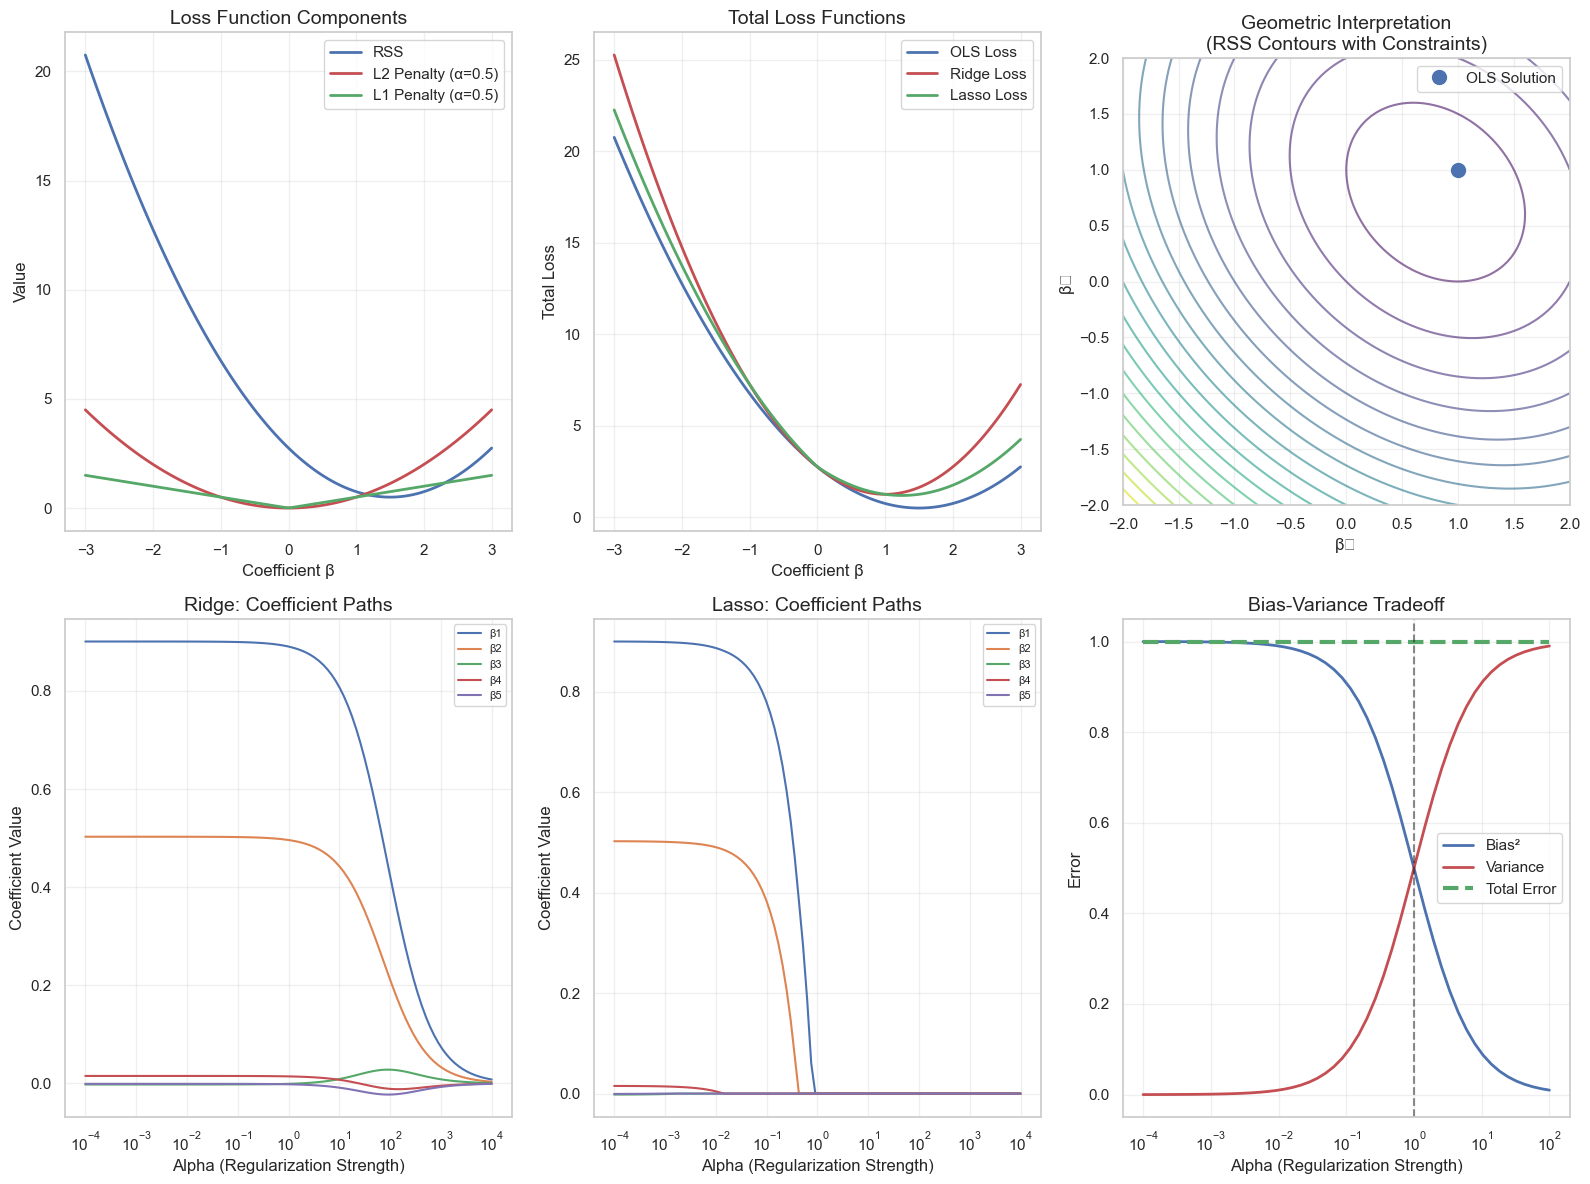


PRACTICAL IMPLEMENTATION

1. Data Preparation:
----------------------------------------
Available columns:
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']
Target variable: median_house_value
Features: ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
Number of features: 6
Training samples: 16512
Test samples: 4128

2. Model Training and Comparison:
----------------------------------------

Training OLS...
  Test R²: 0.5445
  Test MSE: 5968852333.9107
  Non-zero coefficients: 6/6

Training Ridge...
  Test R²: 0.5445
  Test MSE: 5968628339.9581
  Non-zero coefficients: 6/6

Training Lasso...
  Test R²: 0.5445
  Test MSE: 5968844057.9732
  Non-zero coefficients: 6/6

MODEL COMPARISON RESULTS
Model          Train MSE           Test MSE  Train R²  Test R²   Train MAE    Test MAE    Intercept  Non-zero Coefs  Overfit Ratio


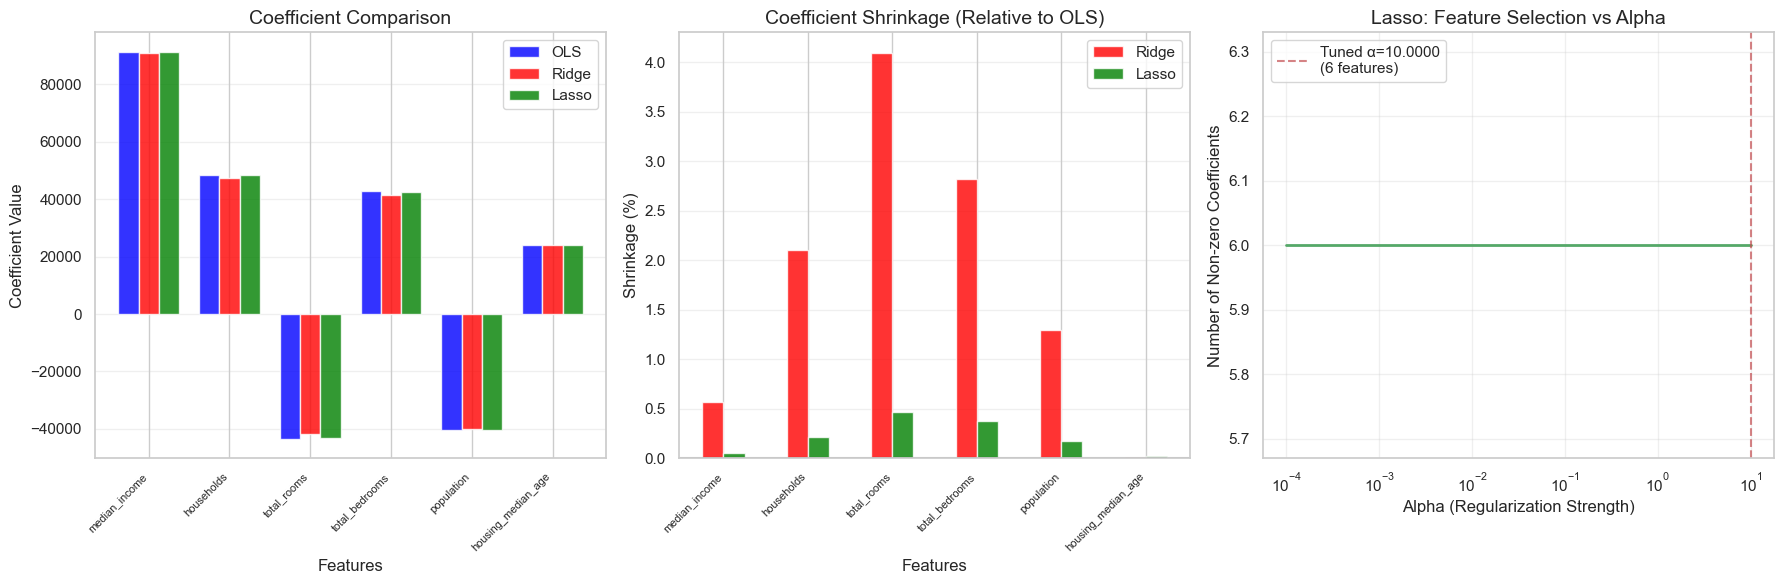


5. Performance Visualization:
----------------------------------------


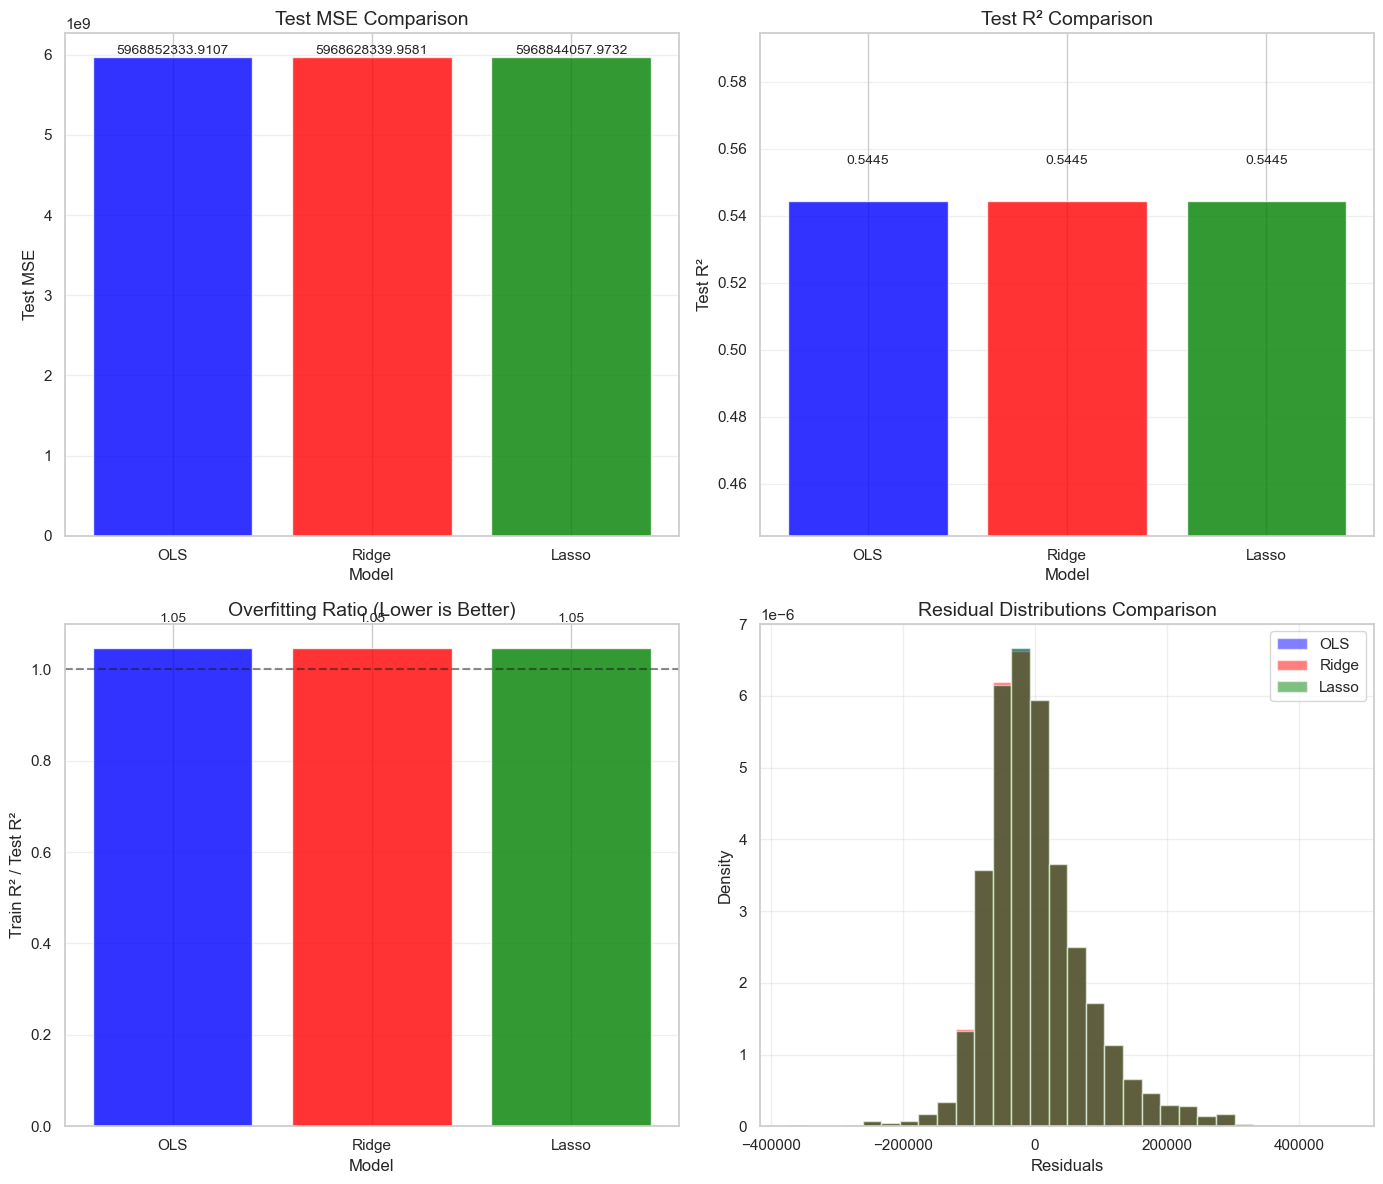


SUMMARY AND INTERPRETATION

KEY INSIGHTS:
----------------------------------------
1. Best performing model: Ridge (Test R² = 0.5445)

2. Overfitting Analysis:
   OLS: Good generalization (ratio = 1.05)
   Ridge: Good generalization (ratio = 1.05)
   Lasso: Good generalization (ratio = 1.05)

3. Coefficient Analysis:
   OLS: All coefficients non-zero
   Ridge: All 6 coefficients non-zero (but shrunk)
   Lasso: 6 non-zero coefficients out of 6 features

4. WHEN TO USE EACH METHOD:
   ───────────────────────────────────
   OLS:
   • When number of samples >> number of features
   • When features are not highly correlated
   • When interpretability is key
   ───────────────────────────────────
   RIDGE REGRESSION:
   • When features are highly correlated (multicollinearity)
   • When all features are potentially relevant
   • To reduce variance without eliminating features
   ───────────────────────────────────
   LASSO REGRESSION:
   • For feature selection (high-dimensional data)
   • 

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set style for better visuals
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("="*70)
print("RIDGE & LASSO REGRESSION WITH VISUAL EXPLANATIONS")
print("="*70)

# 1. THEORETICAL BACKGROUND
print("\n" + "="*70)
print("THEORETICAL EXPLANATION")
print("="*70)

print("\n" + "-"*40)
print("LINEAR REGRESSION PROBLEM")
print("-"*40)

print("""
Ordinary Least Squares (OLS) Regression:
Minimize: RSS = Σ(y_i - ŷ_i)²

Where:
- y_i = Actual value
- ŷ_i = Predicted value = β₀ + β₁x₁ + ... + β_px_p
- RSS = Residual Sum of Squares

Problem with OLS:
1. Overfitting with many features
2. Multicollinearity issues
3. High variance
""")

print("\n" + "-"*40)
print("RIDGE REGRESSION (L2 Regularization)")
print("-"*40)

print("""
Ridge adds L2 penalty to OLS:
Minimize: RSS + α * Σβ_j²

Where:
- α (alpha) = Regularization strength (α ≥ 0)
- Σβ_j² = Sum of squared coefficients (excluding intercept)

Properties:
1. Shrinks coefficients toward zero (but never exactly zero)
2. Reduces model variance
3. Helps with multicollinearity
4. Good when most features are relevant
""")

print("\n" + "-"*40)
print("LASSO REGRESSION (L1 Regularization)")
print("-"*40)

print("""
Lasso adds L1 penalty to OLS:
Minimize: RSS + α * Σ|β_j|

Where:
- α (alpha) = Regularization strength (α ≥ 0)
- Σ|β_j| = Sum of absolute coefficients (excluding intercept)

Properties:
1. Can shrink coefficients exactly to zero (feature selection)
2. Creates sparse models
3. Good when only few features are relevant
4. Better for high-dimensional data
""")

# 2. MATHEMATICAL VISUALIZATION
print("\n" + "="*70)
print("MATHEMATICAL VISUALIZATION")
print("="*70)

# Create visualization of regularization concepts
fig = plt.figure(figsize=(16, 12))

# Plot 1: Loss Function Visualization
ax1 = plt.subplot(2, 3, 1)
# Simulate RSS and penalty terms
beta_values = np.linspace(-3, 3, 100)
rss = (beta_values - 1.5)**2 + 0.5  # Parabolic RSS
ridge_penalty = 0.5 * beta_values**2  # L2 penalty
lasso_penalty = 0.5 * np.abs(beta_values)  # L1 penalty

ax1.plot(beta_values, rss, 'b-', linewidth=2, label='RSS')
ax1.plot(beta_values, ridge_penalty, 'r-', linewidth=2, label='L2 Penalty (α=0.5)')
ax1.plot(beta_values, lasso_penalty, 'g-', linewidth=2, label='L1 Penalty (α=0.5)')
ax1.set_xlabel('Coefficient β', fontsize=12)
ax1.set_ylabel('Value', fontsize=12)
ax1.set_title('Loss Function Components', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Total Loss Comparison
ax2 = plt.subplot(2, 3, 2)
ridge_total = rss + ridge_penalty
lasso_total = rss + lasso_penalty

ax2.plot(beta_values, rss, 'b-', linewidth=2, label='OLS Loss')
ax2.plot(beta_values, ridge_total, 'r-', linewidth=2, label='Ridge Loss')
ax2.plot(beta_values, lasso_total, 'g-', linewidth=2, label='Lasso Loss')
ax2.set_xlabel('Coefficient β', fontsize=12)
ax2.set_ylabel('Total Loss', fontsize=12)
ax2.set_title('Total Loss Functions', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Constraint Visualization (Geometric Interpretation)
ax3 = plt.subplot(2, 3, 3)
# Create contour plot
beta1 = np.linspace(-2, 2, 100)
beta2 = np.linspace(-2, 2, 100)
B1, B2 = np.meshgrid(beta1, beta2)

# RSS surface (elliptical contours)
RSS = (B1 - 1)**2 + (B2 - 1)**2 + B1*B2*0.5

# Constraints
ridge_constraint = B1**2 + B2**2 <= 1  # Circle (L2)
lasso_constraint = np.abs(B1) + np.abs(B2) <= 1  # Diamond (L1)

# Plot contours
contour = ax3.contour(B1, B2, RSS, levels=20, cmap='viridis', alpha=0.6)
ax3.contour(B1, B2, ridge_constraint, levels=[1], colors='red', linewidths=2, label='Ridge (L2)')
ax3.contour(B1, B2, lasso_constraint, levels=[1], colors='green', linewidths=2, label='Lasso (L1)')

# Mark OLS solution
ax3.plot(1, 1, 'bo', markersize=10, label='OLS Solution')

ax3.set_xlabel('β₁', fontsize=12)
ax3.set_ylabel('β₂', fontsize=12)
ax3.set_title('Geometric Interpretation\n(RSS Contours with Constraints)', fontsize=14)
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_aspect('equal')

# Plot 4: Coefficient Paths (Ridge)
ax4 = plt.subplot(2, 3, 4)
# Generate synthetic data for coefficient paths
np.random.seed(42)
n_samples, n_features = 100, 5
X_synth = np.random.randn(n_samples, n_features)
y_synth = X_synth[:, 0] + 0.5*X_synth[:, 1] + 0.1*np.random.randn(n_samples)

# Standardize
scaler = StandardScaler()
X_synth_scaled = scaler.fit_transform(X_synth)

# Compute Ridge paths
alphas = np.logspace(-4, 4, 100)
ridge_coefs = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_synth_scaled, y_synth)
    ridge_coefs.append(ridge.coef_)

ridge_coefs = np.array(ridge_coefs)

for i in range(n_features):
    ax4.plot(alphas, ridge_coefs[:, i], label=f'β{i+1}')

ax4.set_xscale('log')
ax4.set_xlabel('Alpha (Regularization Strength)', fontsize=12)
ax4.set_ylabel('Coefficient Value', fontsize=12)
ax4.set_title('Ridge: Coefficient Paths', fontsize=14)
ax4.legend(loc='upper right', fontsize=8)
ax4.grid(True, alpha=0.3)

# Plot 5: Coefficient Paths (Lasso)
ax5 = plt.subplot(2, 3, 5)
# Compute Lasso paths
lasso_coefs = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_synth_scaled, y_synth)
    lasso_coefs.append(lasso.coef_)

lasso_coefs = np.array(lasso_coefs)

for i in range(n_features):
    ax5.plot(alphas, lasso_coefs[:, i], label=f'β{i+1}')

ax5.set_xscale('log')
ax5.set_xlabel('Alpha (Regularization Strength)', fontsize=12)
ax5.set_ylabel('Coefficient Value', fontsize=12)
ax5.set_title('Lasso: Coefficient Paths', fontsize=14)
ax5.legend(loc='upper right', fontsize=8)
ax5.grid(True, alpha=0.3)

# Plot 6: Bias-Variance Tradeoff
ax6 = plt.subplot(2, 3, 6)
alpha_range = np.logspace(-4, 2, 50)
bias_squared = 1/(1 + alpha_range)  # Simplified representation
variance = alpha_range/(1 + alpha_range)  # Simplified representation
total_error = bias_squared + variance

ax6.plot(alpha_range, bias_squared, 'b-', linewidth=2, label='Bias²')
ax6.plot(alpha_range, variance, 'r-', linewidth=2, label='Variance')
ax6.plot(alpha_range, total_error, 'g--', linewidth=3, label='Total Error')
ax6.set_xscale('log')
ax6.set_xlabel('Alpha (Regularization Strength)', fontsize=12)
ax6.set_ylabel('Error', fontsize=12)
ax6.set_title('Bias-Variance Tradeoff', fontsize=14)
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.axvline(x=1, color='k', linestyle='--', alpha=0.5, label='Optimal α')

plt.tight_layout()
plt.show()

# 3. PRACTICAL IMPLEMENTATION ON CALIFORNIA HOUSING DATA
print("\n" + "="*70)
print("PRACTICAL IMPLEMENTATION")
print("="*70)

# Load and prepare data (assuming df is your California housing DataFrame)
print("\n1. Data Preparation:")
print("-"*40)

# Identify features and target
# First, let's find the actual column names
print("Available columns:")
print(df.columns.tolist())

# Try to automatically identify relevant columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Common California housing columns (adjust as needed)
possible_targets = ['medianHouseValue', 'MedHouseVal', 'target', 'Price', 'median_house_value']
target_col = None
for col in possible_targets:
    if col in numeric_cols:
        target_col = col
        break

if target_col is None and len(numeric_cols) > 0:
    target_col = numeric_cols[-1]  # Use last numeric column as target

# Exclude target and non-predictive columns
exclude_cols = [target_col, 'longitude', 'latitude', 'Id', 'id', 'ID']
features = [col for col in numeric_cols if col not in exclude_cols]

print(f"Target variable: {target_col}")
print(f"Features: {features}")
print(f"Number of features: {len(features)}")

# Prepare data
X = df[features].copy()
y = df[target_col].copy()

# Handle missing values
X = X.fillna(X.median())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

# 4. CREATE AND COMPARE MODELS
print("\n2. Model Training and Comparison:")
print("-"*40)

# Create pipelines for each model
pipelines = {
    'OLS': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    'Ridge': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=1.0))
    ]),
    'Lasso': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(alpha=0.1, max_iter=10000))
    ])
}

# Train and evaluate models
results = []
coefficients = {}

for name, pipeline in pipelines.items():
    print(f"\nTraining {name}...")
    
    # Fit model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Store coefficients
    if name == 'OLS':
        coefficients[name] = pipeline.named_steps['model'].coef_
    else:
        coefficients[name] = pipeline.named_steps['model'].coef_
    
    # Store intercept
    intercept = pipeline.named_steps['model'].intercept_
    
    # Calculate number of non-zero coefficients
    if name == 'Lasso':
        n_nonzero = np.sum(pipeline.named_steps['model'].coef_ != 0)
    else:
        n_nonzero = len(features)
    
    results.append({
        'Model': name,
        'Train MSE': train_mse,
        'Test MSE': test_mse,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Intercept': intercept,
        'Non-zero Coefs': n_nonzero,
        'Overfit Ratio': train_r2 / test_r2 if test_r2 > 0 else float('inf')
    })
    
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Test MSE: {test_mse:.4f}")
    print(f"  Non-zero coefficients: {n_nonzero}/{len(features)}")

# Display results
results_df = pd.DataFrame(results)
print("\n" + "="*70)
print("MODEL COMPARISON RESULTS")
print("="*70)
print(results_df.to_string(index=False))

# 5. HYPERPARAMETER TUNING
print("\n3. Hyperparameter Tuning:")
print("-"*40)

# Define parameter grids
param_grids = {
    'Ridge': {
        'model__alpha': np.logspace(-4, 4, 20)
    },
    'Lasso': {
        'model__alpha': np.logspace(-4, 1, 20)
    }
}

best_models = {}
for name in ['Ridge', 'Lasso']:
    print(f"\nTuning {name} hyperparameters...")
    
    # Create pipeline
    if name == 'Ridge':
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('model', Ridge(max_iter=10000))
        ])
    else:
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('model', Lasso(max_iter=10000))
        ])
    
    # Perform grid search
    grid_search = GridSearchCV(
        pipe, 
        param_grids[name], 
        cv=5, 
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train, y_train)
    
    best_models[name] = grid_search.best_estimator_
    
    print(f"  Best alpha: {grid_search.best_params_['model__alpha']:.6f}")
    print(f"  Best CV score (negative MSE): {grid_search.best_score_:.4f}")
    
    # Evaluate on test set
    y_pred = grid_search.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    print(f"  Test R² with tuned model: {test_r2:.4f}")

# 6. COEFFICIENT COMPARISON VISUALIZATION
print("\n4. Coefficient Analysis:")
print("-"*40)

# Create coefficient comparison plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Get coefficients from tuned models
ridge_coef_tuned = best_models['Ridge'].named_steps['model'].coef_
lasso_coef_tuned = best_models['Lasso'].named_steps['model'].coef_

# Also get OLS coefficients for comparison
ols_pipeline = pipelines['OLS']
ols_pipeline.fit(X_train, y_train)
ols_coef = ols_pipeline.named_steps['model'].coef_

# Create coefficient DataFrame
coef_df = pd.DataFrame({
    'Feature': features,
    'OLS': ols_coef,
    'Ridge': ridge_coef_tuned,
    'Lasso': lasso_coef_tuned
})

# Sort by absolute OLS coefficient value
coef_df['Abs_OLS'] = np.abs(coef_df['OLS'])
coef_df = coef_df.sort_values('Abs_OLS', ascending=False)

# Plot 1: Coefficient values comparison
ax1 = axes[0]
x_pos = np.arange(len(features))
width = 0.25

ax1.bar(x_pos - width, coef_df['OLS'], width, label='OLS', alpha=0.8, color='blue')
ax1.bar(x_pos, coef_df['Ridge'], width, label='Ridge', alpha=0.8, color='red')
ax1.bar(x_pos + width, coef_df['Lasso'], width, label='Lasso', alpha=0.8, color='green')

ax1.set_xlabel('Features', fontsize=12)
ax1.set_ylabel('Coefficient Value', fontsize=12)
ax1.set_title('Coefficient Comparison', fontsize=14)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(coef_df['Feature'], rotation=45, ha='right', fontsize=8)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Coefficient shrinkage
ax2 = axes[1]
# Calculate shrinkage percentage
coef_df['Ridge_Shrinkage'] = (1 - np.abs(coef_df['Ridge']) / np.abs(coef_df['OLS'])) * 100
coef_df['Lasso_Shrinkage'] = (1 - np.abs(coef_df['Lasso']) / np.abs(coef_df['OLS'])) * 100

x_pos = np.arange(len(features))
ax2.bar(x_pos - width/2, coef_df['Ridge_Shrinkage'], width, label='Ridge', alpha=0.8, color='red')
ax2.bar(x_pos + width/2, coef_df['Lasso_Shrinkage'], width, label='Lasso', alpha=0.8, color='green')

ax2.set_xlabel('Features', fontsize=12)
ax2.set_ylabel('Shrinkage (%)', fontsize=12)
ax2.set_title('Coefficient Shrinkage (Relative to OLS)', fontsize=14)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(coef_df['Feature'], rotation=45, ha='right', fontsize=8)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)

# Plot 3: Number of non-zero coefficients vs alpha (for Lasso)
ax3 = axes[2]
# Test different alpha values for Lasso
alphas_lasso = np.logspace(-4, 1, 50)
nonzero_counts = []

for alpha in alphas_lasso:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(StandardScaler().fit_transform(X_train), y_train)
    nonzero_counts.append(np.sum(lasso.coef_ != 0))

ax3.plot(alphas_lasso, nonzero_counts, 'g-', linewidth=2)
ax3.set_xscale('log')
ax3.set_xlabel('Alpha (Regularization Strength)', fontsize=12)
ax3.set_ylabel('Number of Non-zero Coefficients', fontsize=12)
ax3.set_title('Lasso: Feature Selection vs Alpha', fontsize=14)
ax3.grid(True, alpha=0.3)

# Mark the tuned alpha
tuned_alpha = best_models['Lasso'].named_steps['model'].alpha
tuned_nonzero = np.sum(best_models['Lasso'].named_steps['model'].coef_ != 0)
ax3.axvline(x=tuned_alpha, color='r', linestyle='--', alpha=0.7, 
            label=f'Tuned α={tuned_alpha:.4f}\n({tuned_nonzero} features)')
ax3.legend()

plt.tight_layout()
plt.show()

# 7. PERFORMANCE VISUALIZATION
print("\n5. Performance Visualization:")
print("-"*40)

# Create performance comparison plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Test MSE comparison
ax1 = axes[0, 0]
models = results_df['Model']
test_mse = results_df['Test MSE']

bars = ax1.bar(models, test_mse, color=['blue', 'red', 'green'], alpha=0.8)
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Test MSE', fontsize=12)
ax1.set_title('Test MSE Comparison', fontsize=14)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# Plot 2: Test R² comparison
ax2 = axes[0, 1]
test_r2 = results_df['Test R²']

bars = ax2.bar(models, test_r2, color=['blue', 'red', 'green'], alpha=0.8)
ax2.set_xlabel('Model', fontsize=12)
ax2.set_ylabel('Test R²', fontsize=12)
ax2.set_title('Test R² Comparison', fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim([max(0, min(test_r2) - 0.1), min(1, max(test_r2) + 0.05)])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# Plot 3: Overfitting comparison (Train R² / Test R²)
ax3 = axes[1, 0]
overfit_ratio = results_df['Overfit Ratio']

bars = ax3.bar(models, overfit_ratio, color=['blue', 'red', 'green'], alpha=0.8)
ax3.set_xlabel('Model', fontsize=12)
ax3.set_ylabel('Train R² / Test R²', fontsize=12)
ax3.set_title('Overfitting Ratio (Lower is Better)', fontsize=14)
ax3.grid(True, alpha=0.3, axis='y')
ax3.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='No overfitting')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.2f}', ha='center', va='bottom', fontsize=10)

# Plot 4: Residual distributions comparison
ax4 = axes[1, 1]
residuals_dict = {}
for name in ['OLS', 'Ridge', 'Lasso']:
    if name in pipelines:
        pipeline = pipelines[name]
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        residuals_dict[name] = y_test - y_pred

colors = {'OLS': 'blue', 'Ridge': 'red', 'Lasso': 'green'}
for name, residuals in residuals_dict.items():
    ax4.hist(residuals, bins=30, alpha=0.5, label=name, color=colors[name], density=True)

ax4.set_xlabel('Residuals', fontsize=12)
ax4.set_ylabel('Density', fontsize=12)
ax4.set_title('Residual Distributions Comparison', fontsize=14)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8. SUMMARY AND INTERPRETATION
print("\n" + "="*70)
print("SUMMARY AND INTERPRETATION")
print("="*70)

print("\nKEY INSIGHTS:")
print("-"*40)

# Best model determination
best_idx = results_df['Test R²'].idxmax()
best_model = results_df.loc[best_idx, 'Model']
best_r2 = results_df.loc[best_idx, 'Test R²']

print(f"1. Best performing model: {best_model} (Test R² = {best_r2:.4f})")

# Overfitting analysis
print("\n2. Overfitting Analysis:")
for i, row in results_df.iterrows():
    if row['Overfit Ratio'] > 1.1:
        print(f"   {row['Model']}: Shows overfitting (ratio = {row['Overfit Ratio']:.2f})")
    else:
        print(f"   {row['Model']}: Good generalization (ratio = {row['Overfit Ratio']:.2f})")

# Coefficient analysis
print("\n3. Coefficient Analysis:")
print("   OLS: All coefficients non-zero")
print(f"   Ridge: All {len(features)} coefficients non-zero (but shrunk)")
print(f"   Lasso: {tuned_nonzero} non-zero coefficients out of {len(features)} features")

if tuned_nonzero < len(features):
    # Identify which features were eliminated by Lasso
    lasso_coef = best_models['Lasso'].named_steps['model'].coef_
    eliminated_features = [features[i] for i in range(len(features)) if lasso_coef[i] == 0]
    print(f"   Features eliminated by Lasso: {eliminated_features}")

# Practical recommendations
print("\n4. WHEN TO USE EACH METHOD:")
print("   " + "─" * 35)
print("   OLS:")
print("   • When number of samples >> number of features")
print("   • When features are not highly correlated")
print("   • When interpretability is key")
print("   " + "─" * 35)
print("   RIDGE REGRESSION:")
print("   • When features are highly correlated (multicollinearity)")
print("   • When all features are potentially relevant")
print("   • To reduce variance without eliminating features")
print("   " + "─" * 35)
print("   LASSO REGRESSION:")
print("   • For feature selection (high-dimensional data)")
print("   • When only few features are truly relevant")
print("   • To create simpler, more interpretable models")
print("   " + "─" * 35)

# Final recommendations
print("\n5. RECOMMENDATIONS FOR THIS DATASET:")
print("   " + "─" * 35)
if best_model == 'Lasso' and tuned_nonzero < len(features):
    print(f"   • Use Lasso with α={tuned_alpha:.4f}")
    print(f"   • Focus on the {tuned_nonzero} selected features")
    print(f"   • Features eliminated: {len(features) - tuned_nonzero}")
elif best_model == 'Ridge':
    print(f"   • Use Ridge with α={best_models['Ridge'].named_steps['model'].alpha:.4f}")
    print("   • All features contribute to predictions")
else:
    print("   • OLS works well, consider regularization only if overfitting occurs")

print("\n" + "="*70)
print("END OF RIDGE & LASSO ANALYSIS")
print("="*70)